# Automatic Personality Prediction
<center><img src="./images/header.png" alt="drawing" style="width:200px;"/></center>

#### by Weston Shuken

---

## Overview

Automatic personality detection is the automated forecasting of a personality using human-generated or exchanged contents:

- text
- speech
- videos
- images


## Opportunities

![Opp](./images/opp.png)

There are great opportunities that stem from this project and research:

1) Verifying validity in Myers-Briggs abilitity to segment on behavior, given the MBTI is often criticized for being unreliable (). (Kerwin, P.L., 2017). [[Download Research Paper](https://www.psychometrics.com/wp-content/uploads/2018/06/Creating-Clarity-Addressing-Micsconceptions-About-the-MBTI-Assessment-WhitePaper-1.pdf)]

2) Classifying online behavior. Text-rich platforms like social media, blogs, and forums can use implicit data to segment their customers. This segmentation is a common use of automatic personality detection, which can be used for "advertisements alignment, marketing campaigns adjustment, and supporting bloggers in narrowing down their target audiences based on community pre-detected personality traits" (Tareaf, Berger, et. al, 2018). [[Download Reaserch Paper](https://arxiv.org/pdf/1812.04346)]

3) The ability for speed and quantity of classification using automated prediction allows for bypassing questionnaire strategies. If accurate enough, populations of people and their personalities/online behavoirs could be better understood. This would add a drop in the ocean of knowledge in this widely researched topic ( Sharmaa, E., Mahajanb R., & Mansotrad, V., 2021). [[Download Research Paper](https://www.researchgate.net/publication/356603183_Automated_Personality_Prediction_of_Social_Media_Users_A_Decade_Review)]


## Data and Methods

The data used to make predictions is a collection of 50 posts per ~8,600 users on a forum-based website: [Personality Cafe](https://www.personalitycafe.com/). All of the users have self-tagged their profiles with thier Myers-Briggs Type Indicator (MBTI) personality. These personality types will be used as the **target** variables, and the collection of posts will be the **predictor** variables.

The Myers-Briggs test is a very popular test that ask users approximately 90 questions about their behavior and assigns the user a type of personality based on this assessment. This test takes around 20-30 for someone to complete. 

There are 16 different personality types using a combination of 8 overall traits. See below:

    Introversion (I) vs Extroversion (E)
    Intuition (N) vs Sensing (S)
    Thinking (T) vs Feeling (F)
    Judging (J) vs Perceiving (P)
    
*If you are unfamilar with the MBTI, please visit [Myers-Briggs Type Indicator](https://www.myersbriggs.org/my-mbti-personality-type/mbti-basics/) for more info*

Various methods were used to preprocess, vectorize, and predict:

Preprocessing Methods:

    Lowercase all words
    Remove URLs
    Remove Punctuation and symbols
    Remove non-ASCII characters
    Remove Digits
    Tokenizing
    Lemmatizing w/ POS tags
    Create binary labels
    
Sentiment Analysis

    NLTK VADER
    TextbBlob 

Vectorization Strategies:
    
    Bag of Words
    Term Frequency-Inverse Document Frequency (TF-IDF)
    Doc2Vec (Gensim)
    
Machine Learnging Models:
    
    Stochastic Gradient Descent Classifier
    Logistic Regression
    Random Forest
    Mutlinominal Naive Bayes
    
 Evaluation Methods/Metrics:
    
    Train Test Split
    Accuracy
    F1-Score
    Testing on Reddit data

## Exploratory Data Analysis

In [2]:
# Imports for EDA, Cleaning, Plotting & Modeling
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle

from nltk.tokenize import RegexpTokenizer
from nltk.probability import FreqDist
from nltk.sentiment.vader import SentimentIntensityAnalyzer


from scipy.stats import binom

from textblob import TextBlob

from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.linear_model import SGDClassifier, LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import plot_confusion_matrix, accuracy_score, classification_report
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier

import gensim


from nlp import run_models, preprocess

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# Random Seed for everything
SEED = 53188535

In [3]:
# Loading the Data (From Kaggle — https://www.kaggle.com/datasnaek/mbti-type)
cafe_df = pd.read_csv('data/mbti_1.csv')

In [4]:
# Viewing the dataset
cafe_df

,type,posts
0,INFJ,'http://www.youtube.com/watch?v=qsXHcwe3krw|||...
1,ENTP,'I'm finding the lack of me in these posts ver...
2,INTP,'Good one _____ https://www.youtube.com/wat...
3,INTJ,"'Dear INTP, I enjoyed our conversation the o..."
4,ENTJ,'You're fired.|||That's another silly misconce...
...,...,...
8670,ISFP,'https://www.youtube.com/watch?v=t8edHB_h908||...
8671,ENFP,'So...if this thread already exists someplace ...
8672,INTP,'So many questions when i do these things. I ...
8673,INFP,'I am very conflicted right now when it comes ...


In [5]:
# Checking the dataset size and data types
cafe_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8675 entries, 0 to 8674
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   type    8675 non-null   object
 1   posts   8675 non-null   object
dtypes: object(2)
memory usage: 135.7+ KB


In [6]:
# Checking class imbalance
cafe_df['type'].value_counts(normalize=True)

INFP    0.211182
INFJ    0.169452
INTP    0.150317
INTJ    0.125764
ENTP    0.078963
ENFP    0.077810
ISTP    0.038847
ISFP    0.031239
ENTJ    0.026628
ISTJ    0.023631
ENFJ    0.021902
ISFJ    0.019135
ESTP    0.010259
ESFP    0.005533
ESFJ    0.004841
ESTJ    0.004496
Name: type, dtype: float64

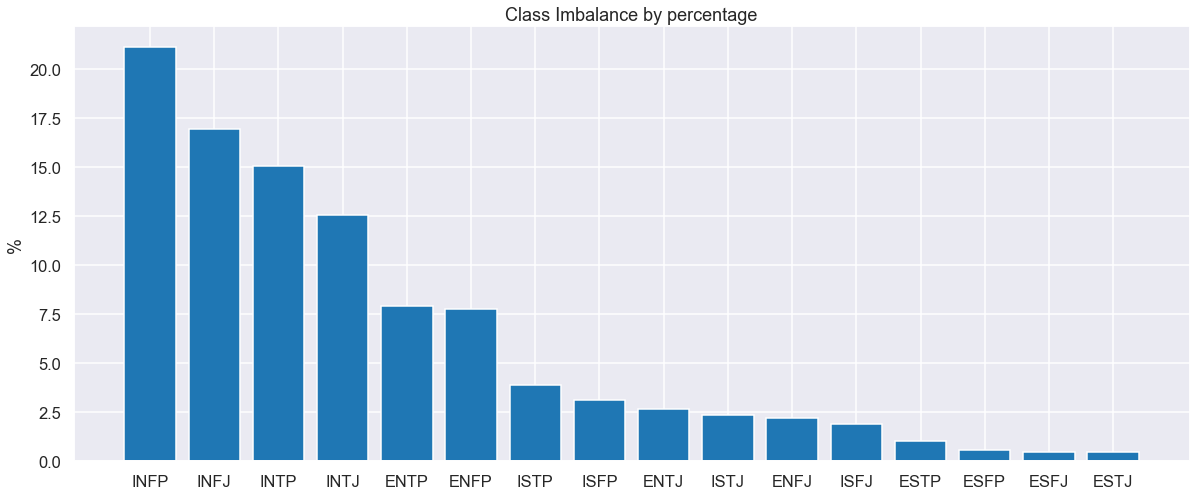

In [7]:
# Plotting class imbalance
sns.set_context('talk')
sns.set_style('darkgrid')
plt.figure(figsize=(20,8))
plt.bar(cafe_df['type'].value_counts(normalize=True).index, cafe_df['type'].value_counts(normalize=True).values*100)
plt.title('Class Imbalance by percentage')
plt.ylabel('%');

In [8]:
# looking at a random post for the data — Re-run cell to generate new post
rint = np.random.randint(0, len(cafe_df))
print('>'*10 + cafe_df['type'].iloc[rint] + '<'*10)
print('-'*25)
print(cafe_df['posts'].iloc[rint][:1000])

## BE CAREFUL... Reddit posts can sometimes be quite rude...

>>>>>>>>>>INTP<<<<<<<<<<
-------------------------
'I think it depends, Introverted J types definitely prefer to think before acting (cautious) but Introverted P types are often a mix of quiet reflection and spontaneous action. As a INTP I take action...|||Just skipped to the end of the thread and I was pretty much in the ball park.:proud: When answered your first post I did not look at any of the other guesses.|||I'm  going to say xNFP pointing more ENFP.|||(  Yeah the Buddha is heavily Ti and Ni, and I see Se much more than Fe. It sounds like he was a hedonistic SP when younger then began developing a deep Ni perspective after his after a stretch of...|||Tony Stark is such a clear ENTP, he's not Ne just because he is humorous and smart, he's Ne because that is his dominant approach to life(in the films). He is completely off the cuff and...|||Open-Mindedness     High scorers tend to be original, creative, curious, complex; Low scorers tend to be conventional, down to earth, narrow in

#### Takeaways from seeing the dataset:

- The classes are quite imbalanced, which can bias the model to choosing one class over the other just given class weight.
- There is a lot of cleaning to do with the text (lowercase, remove urls, remove symbols/punctuation, lemmitization, etc.)
- The posts might include the personality type in them, which could be considered `data leakage`.

### Cleaning & Tokenizing

In [9]:
# Making a copy of the DataFrame to clean and preprocess
cafe_clean = cafe_df.copy()

In [10]:
# Lowercase y variables (MBTI types)
cafe_clean['type'] = cafe_clean.type.str.lower()

# Creating list of the targets (Useful for later iteration)
mbti_lst = list(set(cafe_clean['type'].values))
print(mbti_lst)

# Lowercase X varaible onto a new column (User Posts)
cafe_clean['clean_posts'] = cafe_clean['posts'].str.lower()

['istj', 'intp', 'intj', 'estp', 'infp', 'enfp', 'istp', 'entj', 'entp', 'esfj', 'isfp', 'isfj', 'estj', 'esfp', 'infj', 'enfj']


In [11]:
# Intiating the prepreoccess class from the custom class — nlp.py
# This class provides functions to clean and tokenize our text data — view the python file for more info
prepro = preprocess()

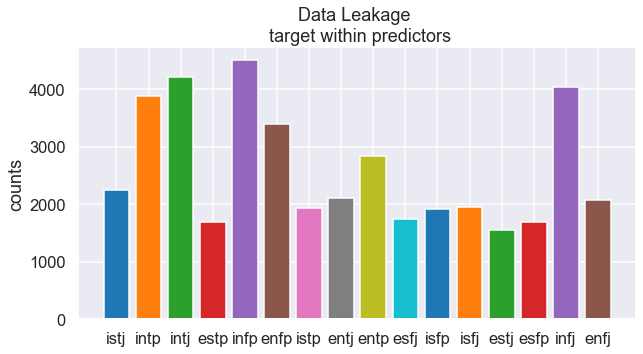

In [12]:
# Plotting the occurrences of data leakage where MBTI type is stated in post
plt.figure(figsize=(10,5))
for mbti in mbti_lst:
    plt.bar(str(mbti), len(cafe_clean[cafe_clean['clean_posts'].str.contains(mbti)].index))
    plt.title('Data Leakage \n target within predictors')
    plt.ylabel('counts')
    # print(cafe_clean[cafe_clean['clean_posts'].str.contains(mbti)].index)

In [13]:
# Removing the target names (MBTI type) in the actual posts
cafe_clean['clean_posts'] = cafe_clean['clean_posts'].apply(lambda x: prepro.replace_mbti(x))

In [14]:
# Cross checking to see if posts contain MBTI type
for mbti in mbti_lst:
    print(cafe_clean[cafe_clean['clean_posts'].str.contains(mbti)].index)

Int64Index([], dtype='int64')
Int64Index([], dtype='int64')
Int64Index([], dtype='int64')
Int64Index([], dtype='int64')
Int64Index([], dtype='int64')
Int64Index([], dtype='int64')
Int64Index([], dtype='int64')
Int64Index([], dtype='int64')
Int64Index([], dtype='int64')
Int64Index([], dtype='int64')
Int64Index([], dtype='int64')
Int64Index([], dtype='int64')
Int64Index([], dtype='int64')
Int64Index([], dtype='int64')
Int64Index([], dtype='int64')
Int64Index([], dtype='int64')


In [15]:
# The posts contain multiple posts seperated by 3 pipes '|||' w/ no spaces between. 
# This function will remove pipes and replace with a space.
cafe_clean['clean_posts'] = cafe_clean['clean_posts'].apply(lambda x: prepro.pipe_remove(x))

# This funciton will remove URLs in the posts
cafe_clean['clean_posts'] = cafe_clean['clean_posts'].apply(lambda x: prepro.url_remove(x))

# This function will remove punctuation `/``, `_`, `:` 
cafe_clean['clean_posts'] = cafe_clean['clean_posts'].apply(lambda x: prepro.punc_remove(x))

# Removes all characters that are not American Standard Code for Information Interchange (aka english chars)
cafe_clean['clean_posts'] = cafe_clean['clean_posts'].apply(lambda x: prepro.remove_symbols(x))

# Fixes all spelling errors — this takes a long time to compute.
# cafe_clean['clean_posts'] = cafe_clean['clean_posts'].apply(lambda x: prepro.spelling(x))

In [16]:
# This will create a column of cleaned posts that have been tokenized.
pattern = r"(?u)\b\w\w+\b" # words with 2 or more etters
tokenizer = RegexpTokenizer(pattern) # instantiate tokenizer
cafe_clean['post_tokens'] = cafe_clean['clean_posts'].apply(tokenizer.tokenize) # Tokenize to new column

In [17]:
# Removing any remaining numeric digits
cafe_clean['post_tokens'] = cafe_clean['post_tokens'].apply(lambda x: prepro.remove_dig_token(x))

# Removing stopwords (common words with little informational value)
cafe_clean['post_tokens'] = cafe_clean['post_tokens'].apply(lambda x: prepro.remove_stopwords(x))

# Lemmatizing the words with POS tagging option
cafe_clean['post_tokens'] = cafe_clean['post_tokens'].apply(lambda x: prepro.lemmend_pos(x, pos=True)) # If True, takes a while (~4mins on Apple M1)

In [18]:
# Joining the posts tokens together into singular strings
cafe_clean['joined_tokens'] = cafe_clean['post_tokens'].apply(lambda x: prepro.join_tokens(x)) # Creating new column

In [19]:
# Showing what characters are in the cleaned text vs. the pre-cleaned text
clean_corpus = ' '.join(cafe_clean['joined_tokens'])
print(f'CLEANED: {"".join(sorted(set(clean_corpus.lower())))}')
print('-'*25)
print('-'*25)
print('-'*25)

corpus = ' '.join(cafe_df['posts'])
print(f'PRE-CLEANED: {"".join(sorted(set(corpus.lower())))}')

CLEANED:  abcdefghijklmnopqrstuvwxyz
-------------------------
-------------------------
-------------------------
PRE-CLEANED:  !#$%&'()*+,-./0123456789:;<=>?@[]^_`abcdefghijklmnopqrstuvwxyz{|}~¡¢£¤§¨©«¬®¯°²³´µ¶·¸¹º»¼½¾¿×ßàáâãäåæçèéêëìíîïðñòóôõö÷øùúûüýþÿāăćčđēĕėęěīĭıłńōŏőœřśšūżưǝɐɔəɛɟɥɪɯɹʇʊʌʍʎʒʖʘ˂˃ˆˈˌː˘˙˚˝˶̴̶̸̡̢̧̨̛̖̗̘̙̜̝̞̟̠̣̤̥̦̩̪̫̬̯̰̳̹̺̻̼͇͈͉͍͎̀́̂̃̄̆̇̈̉̌̎̐̑̒̓̔̽̾́̓͊̕̚ͅ͏͓͔͕͖͙͚͑͒͛ͣͤͥͦͧͨͩͫͭͮ͘͜͟͢͝͞͡άέήίαβγδεηθικλμνξοπρςστυφψωόύώабвгдежзийклмнопрстуфхцчшщъыьэюяћќ҉אבגדהוזחיךלםמןנסעפץרשת،؟أابةتثجحدرزسشظعغفقكلمنهوي٩کگی۶ःतमरिू्ஐ௰ಠಡಥರೃฅง็๑ຈ༼༽ლღᆺ፦ᴗởἓἔἶὅὐὲ–—―‘’‚“”„†•…′‽‿⁎₪€™↑→↔⇑⇩∀∇∈∑−∙√∞≈≠≡≥≦≧⊃⊙⋆⌒⌣─━┌┐┬┻╥╬╭╮╯■□▬△▽◇◉●◔◕◞◠◡☂★☆☺☼♉♡♢♤♥♧♪♫♬✌✍✓✔✝✧✨✿❤⸮、。》あいうえおかがきぎくこごさざしじすせぜそただちっつづてでとなにねのはへぼまめもゃやょよらりるれろわをん゜アイクサジタッツトニノミメモュラレヮワン・ーヽヾㅿ一上不中之习了事二人仙会但你便像光全兴冬刀利到勇吉同吗吞呢喜四因国地夜夢大天太头好如学安実容小就弁待很我才把抜拿掌文斎斬新方日明易是智暗曉月望本柳欢気汉漫為然爱狼王白的益眼砂祥私笑組美聖花英菀西見語语说迎返違選都野関陰陽雪願馬髒高龍녕디랑뮤보비사석세씨아안오요유재저직하️︵﹏！％＇（）＊，－０１：；？＠｀ａｂｃｄｅｆｇｈｉｋｌｍｎｏｐｒｓｔｕｖｗｘｙ～｡･ｧｩｫｬｼﾉﾞﾟ￣�🌹🍄🏼🐍👈👋👌👍👏💎💓💖💛🔥🕚😀😁😂😃😄😅😆😇😉😊😋😌😍😎😏😐😓😕😘😜😝😞😡😢😣😧😫😬😮😱😳😴😺🙋🤓🤔🤗🦄


In [20]:
# Viewing the clean DataFrame and its new columns
cafe_clean.head(5)

,type,posts,clean_posts,post_tokens,joined_tokens
0,infj,'http://www.youtube.com/watch?v=qsXHcwe3krw|||...,and moments sportscenter not top te...,"[moment, sportscenter, top, ten, play, pranks,...",moment sportscenter top ten play pranks life c...
1,entp,'I'm finding the lack of me in these posts ver...,im finding the lack of me in these posts very ...,"[im, find, lack, post, alarm, sex, boring, pos...",im find lack post alarm sex boring position of...
2,intp,'Good one _____ https://www.youtube.com/wat...,"good one of course, to which i say i kn...","[good, one, course, say, know, thats, bless, c...",good one course say know thats bless curse abs...
3,intj,"'Dear INTP, I enjoyed our conversation the o...","dear , i enjoyed our conversation the other ...","[dear, enjoyed, conversation, day, esoteric, g...",dear enjoyed conversation day esoteric gabbing...
4,entj,'You're fired.|||That's another silly misconce...,youre fired. thats another silly misconcepti...,"[youre, fire, thats, another, silly, misconcep...",youre fire thats another silly misconception a...


The pre-cleaned tokens tally up to 10637645 total words
The cleaned tokens tally up to 5378285 total words
--------------------
Each feature in pre-cleaned has on average 1226 words
Each feature in cleaned has on average 620 words
--------------------
Each feature in pre-cleaned  has a median of 1278 words
Each feature has a median of 645 words
--------------------
The minimum post in pre-cleaned  is 4 words
The minimum post in cleaned is 0 words
--------------------
The minimum post in pre-cleaned  is 1881 words
The minimum post in cleaned is 916 words
--------------------


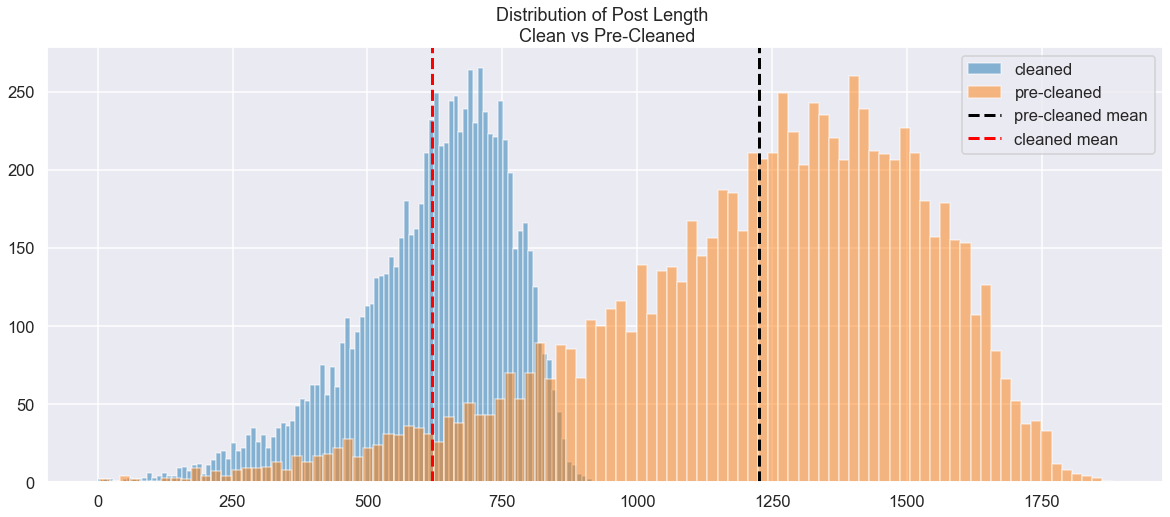

In [21]:
# Visualizing the distributions of posts by length from pre-cleaned and cleaned posts

total_words = cafe_clean['posts'].apply(lambda x: len(x.split())).sum() # Finding total words in pre-cleaned corupus
print(f'The pre-cleaned tokens tally up to {total_words} total words')

clean_words = cafe_clean['post_tokens'].apply(lambda x: len(x)).sum() # Finding total words in cleaned corupus
print(f'The cleaned tokens tally up to {clean_words} total words')

print('-'*20)

ave_post = cafe_clean['posts'].apply(lambda x: len(x.split())).mean() # Finding average total words in pre-cleaned corupus
print(f'Each feature in pre-cleaned has on average {round(ave_post)} words')

ave_cleaned = cafe_clean['post_tokens'].apply(lambda x: len(x)).mean() # Finding average total words in cleaned corupus
print(f'Each feature in cleaned has on average {round(ave_cleaned)} words') 

print('-'*20)

med_post = cafe_clean['posts'].apply(lambda x: len(x.split())).median()  # Finding median total words in pre-cleaned corupus
print(f'Each feature in pre-cleaned  has a median of {round(med_post)} words')

med_cleaned = cafe_clean['post_tokens'].apply(lambda x: len(x)).median() # Finding median total words in cleaned corupus
print(f'Each feature has a median of {round(med_cleaned)} words')

print('-'*20)

min_post = cafe_clean['posts'].apply(lambda x: len(x.split())).min() # Finding minimum words count in pre-cleaned corupus
print(f'The minimum post in pre-cleaned  is {round(min_post)} words')

min_cleaned = cafe_clean['post_tokens'].apply(lambda x: len(x)).min() # Finding minimum words count in cleaned corupus
print(f'The minimum post in cleaned is {round(min_cleaned)} words')

print('-'*20)

max_post = cafe_clean['posts'].apply(lambda x: len(x.split())).max() # Finding maximum words count in pre-cleaned corupus
print(f'The minimum post in pre-cleaned  is {round(max_post)} words')

max_cleaned = cafe_clean['post_tokens'].apply(lambda x: len(x)).max() # Finding maximum words count in cleaned corupus
print(f'The minimum post in cleaned is {round(max_cleaned)} words')

print('-'*20)

# Plotting the distributions
plt.figure(figsize=(20,8))
plt.hist(cafe_clean['post_tokens'].apply(lambda x: len(x)), label='cleaned', alpha=.5, bins=100)
plt.hist(cafe_clean['posts'].apply(lambda x: len(x.split())), label='pre-cleaned', alpha=.5, bins=100)
plt.axvline(ave_post, color='k', linestyle='dashed', linewidth=3, label='pre-cleaned mean')
plt.axvline(ave_cleaned, color='r', linestyle='dashed', linewidth=3, label='cleaned mean')
plt.legend()
plt.title('Distribution of Post Length \n Clean vs Pre-Cleaned');

In [22]:
# Printing random slices of posts comparted to clean posts.
rint = np.random.randint(0, len(cafe_df))
print('>'*10 + cafe_df['type'].iloc[rint] + '<'*10)
print('-'*25)
print(cafe_clean['posts'].iloc[rint][:2000])
print('-'*25)
print(cafe_clean['joined_tokens'].iloc[rint][:2000])

>>>>>>>>>>INFP<<<<<<<<<<
-------------------------
'TL;DR means: Too long; didn't read. :)|||I really enjoy personal, one-on-one interactions with people, especially if they are in warm and accepting environments. Otherwise, as more people (so that it is more than, say, 4 or 5), noise, and...|||P.S. In the end, though, I don't think MBTI makes a huge difference in whom you may seek a long-term romantic relationship with. It really depends on the person. However, I won't deny that there are...|||From my personal experiences, any Fe-dom and I are going to be a huge no-no. This is because Fe-doms make me distinctly uncomfortable in a way that I cannot place. There is just something very...|||^ Totally see the Fi from one glance at your About Me.   Made me laugh: This section is stalker proof and is only available to close friends. I stalked regardless.  I would say ESFP fits you...|||Siren|||I get along with a good amount of NFs. I have an (I believe to be) INFJ friend who is such a joy t

#### Preprocessing/Data Cleaning Takeaways:
- A lot of words were reduced or eliminated that did not provide any use.
- The dataset still has posts with very little words. Might need to drop these.
- The lemmitization did not work well on some verbs and the `MBTI` replacement often is followed by an `s`.


#### Binary Classes

In [23]:
# Adding Binary Targets
cafe_clean['i/e'] = cafe_clean['type'].map(lambda x: x[0])
cafe_clean['n/s'] = cafe_clean['type'].map(lambda x: x[1])
cafe_clean['t/f'] = cafe_clean['type'].map(lambda x: x[2])
cafe_clean['p/j'] = cafe_clean['type'].map(lambda x: x[3])

In [24]:
# Checking the Binary Target class imbalance
print(cafe_clean['i/e'].value_counts(normalize=True))
print(cafe_clean['n/s'].value_counts(normalize=True))
print(cafe_clean['t/f'].value_counts(normalize=True))
print(cafe_clean['p/j'].value_counts(normalize=True))

i    0.769568
e    0.230432
Name: i/e, dtype: float64
n    0.862017
s    0.137983
Name: n/s, dtype: float64
f    0.541095
t    0.458905
Name: t/f, dtype: float64
p    0.60415
j    0.39585
Name: p/j, dtype: float64


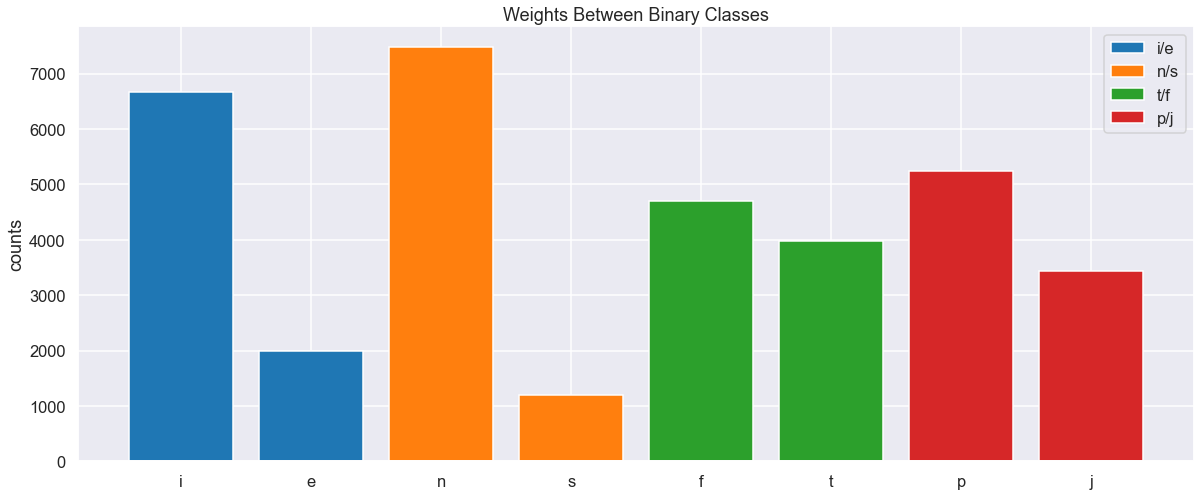

In [25]:
# Plotting the Binary Target Class Imbalance
plt.figure(figsize=(20,8))
plt.title('Weights Between Binary Classes')
plt.ylabel('counts')
for column in cafe_clean.columns[-4:]:
    plt.bar(cafe_clean[column].value_counts().index, cafe_clean[column].value_counts().values, label=column)

plt.legend()
plt.show();

### Sentiment Analysis
Checking for insights based on post sentiment analysis

In [26]:
# Instantiating NLTK VADER Sentiment Analyzer
sid = SentimentIntensityAnalyzer()

In [27]:
# Testing Polarity Scores
sid.polarity_scores(cafe_clean.loc[2,'joined_tokens'])

{'neg': 0.109, 'neu': 0.599, 'pos': 0.292, 'compound': 0.9985}

In [28]:
# Applying Polarity Scores as a column
cafe_clean['sentiment'] = cafe_clean['joined_tokens'].apply(lambda x: sid.polarity_scores(x))

In [29]:
# Isolating the `compound` score to its own column
cafe_clean['sentiment_total'] = cafe_clean['sentiment'].apply(lambda x: x['compound'])

In [30]:
# Applying a binary sentiment score to a column
cafe_clean['sentiment_score'] = cafe_clean['sentiment_total'].apply(lambda x: '+' if x >= 0 else '-')

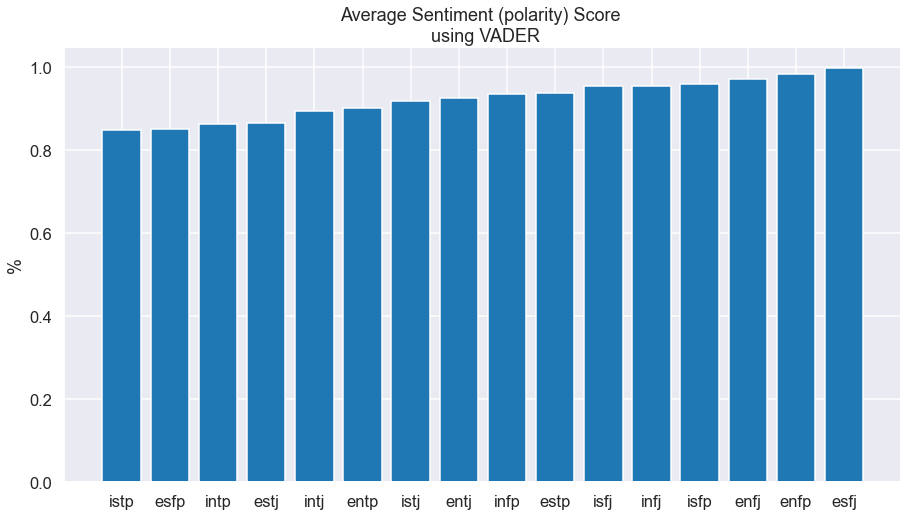

In [31]:
# Printing and visualizing the average polarity score by MBTI type
scores_dict = {}
for mbti in mbti_lst:
    data = cafe_clean[cafe_clean['type'] == mbti]
    # print(f'Average Sentiment Score for {mbti}: {data.sentiment_total.mean()}')
    scores_dict.update({mbti: data.sentiment_total.mean()}) 

scores_dict = {k: v for k, v in sorted(scores_dict.items(), key=lambda item: item[1])}

x = list(scores_dict.keys())
height = list(scores_dict.values())

plt.figure(figsize=(15,8))
plt.bar(x, height)
plt.ylabel('%')
plt.title('Average Sentiment (polarity) Score \n using VADER');


In [32]:
# Applying TextBlob Sentiment Polarity Score to new column for cross checking 
cafe_clean['polarity'] = cafe_clean['joined_tokens'].apply(lambda x: TextBlob(x).sentiment.polarity)

In [33]:
# Applying TextBlob Subjectivity Score to new column
cafe_clean['subjectivity'] = cafe_clean['joined_tokens'].apply(lambda x: TextBlob(x).sentiment.subjectivity)

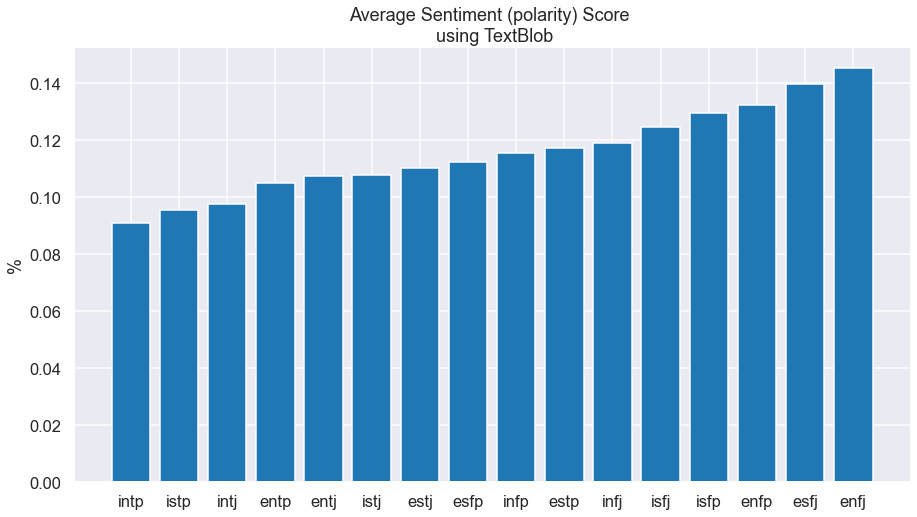

In [34]:
# Printing and visualizing the average polarity score by MBTI type (TextBlob)
scores_dict = {}
for mbti in mbti_lst:
    data = cafe_clean[cafe_clean['type'] == mbti]
    # print(f'Average Sentiemnt Score for {mbti}: {data.polarity.mean()}')
    scores_dict.update({mbti: data.polarity.mean()}) 

scores_dict = {k: v for k, v in sorted(scores_dict.items(), key=lambda item: item[1])}

x = list(scores_dict.keys())
height = list(scores_dict.values())

plt.figure(figsize=(15,8))
plt.bar(x, height)
plt.ylabel('%')
plt.title('Average Sentiment (polarity) Score \n using TextBlob');

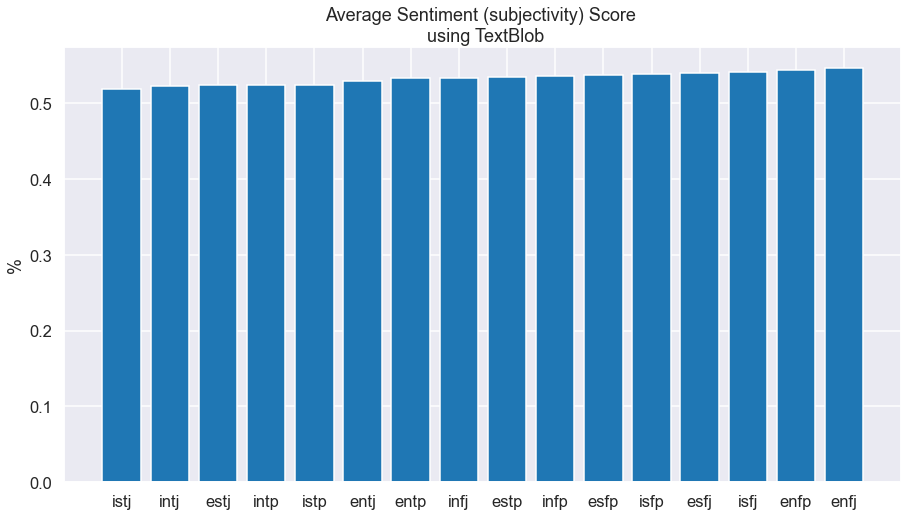

In [35]:
scores_dict = {}
for mbti in mbti_lst:
    data = cafe_clean[cafe_clean['type'] == mbti]
    # print(f'Average Sentiemnt Score for {mbti}: {data.subjectivity.mean()}')
    scores_dict.update({mbti: data.subjectivity.mean()}) 

scores_dict = {k: v for k, v in sorted(scores_dict.items(), key=lambda item: item[1])}

x = list(scores_dict.keys())
height = list(scores_dict.values())

plt.figure(figsize=(15,8))
plt.bar(x, height)
plt.ylabel('%')
plt.title('Average Sentiment (subjectivity) Score \n using TextBlob');

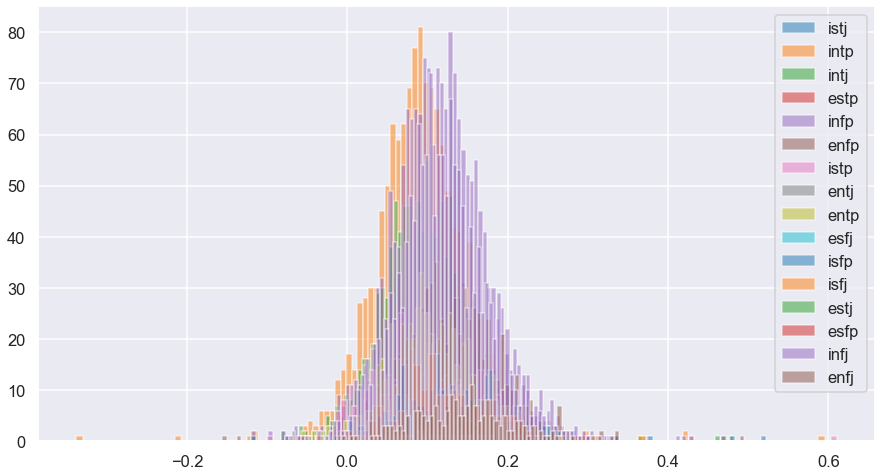

In [36]:
# Plotting the distributions of polarity scores by MBTI type
plt.figure(figsize=(15,8))
for mbti in mbti_lst:
    plt.hist(cafe_clean['polarity'][cafe_clean['type'] == mbti], bins=100, alpha=.5, label=mbti)
    plt.legend();

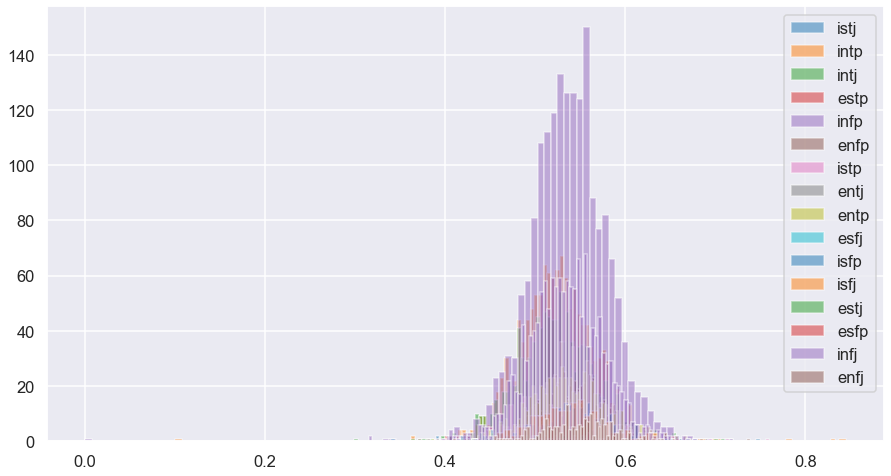

In [37]:
# Plotting the distributions of subjectivity scores by MBTI type
plt.figure(figsize=(15,8))
for mbti in mbti_lst:
    plt.hist(cafe_clean['subjectivity'][cafe_clean['type'] == mbti], bins=100, alpha=.5, label=mbti)
    plt.legend();

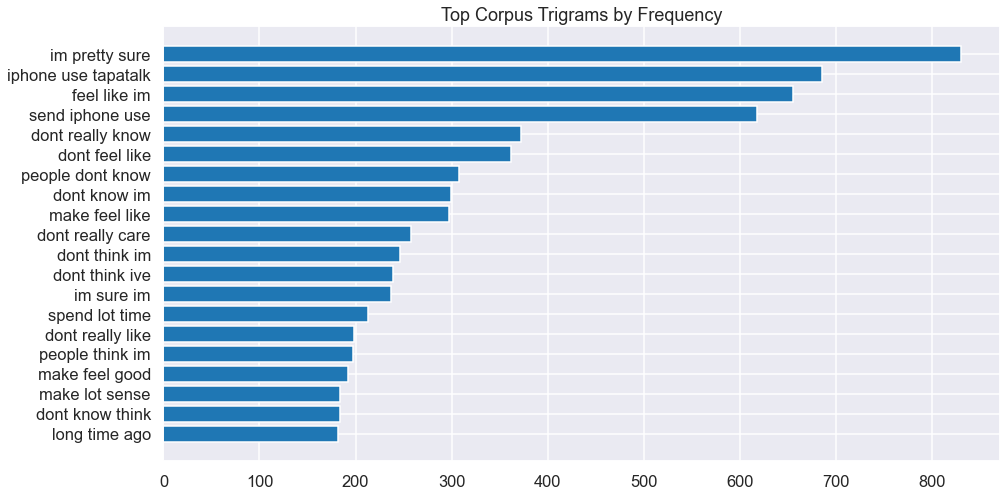

In [38]:
# Plotting top tri-grams by frequency of the entire corpus — code shoutout to Susan Li (https://actsusanli.medium.com/)
def get_top_n_trigram(corpus, n=None):
    vec = CountVectorizer(ngram_range=(3, 3), stop_words='english').fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]
common_words = get_top_n_trigram(cafe_clean['joined_tokens'], 20)
df_tgrams = pd.DataFrame(common_words, columns = ['Posts' , 'count'])
df_tgrams = df_tgrams.groupby('Posts').sum()['count'].sort_values(ascending=True)
plt.figure(figsize=(15,8))
plt.barh(df_tgrams.index, df_tgrams.values)
plt.title('Top Corpus Trigrams by Frequency');


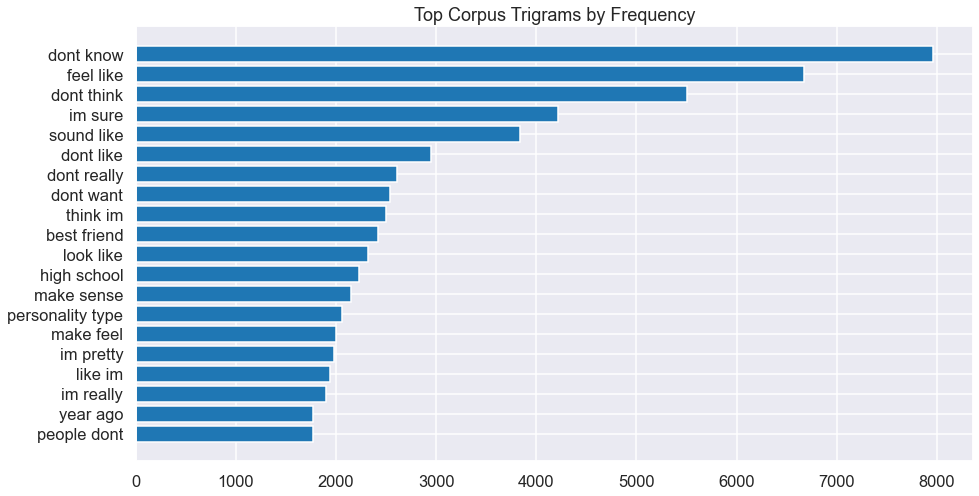

In [39]:
# Plotting top bi-grams by frequency of the entire corpus — code shoutout to Susan Li (https://actsusanli.medium.com/)
def get_top_n_trigram(corpus, n=None):
    vec = CountVectorizer(ngram_range=(2, 2), stop_words='english').fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]
common_words = get_top_n_trigram(cafe_clean['joined_tokens'], 20)
df_tgrams = pd.DataFrame(common_words, columns = ['Posts' , 'count'])
df_tgrams = df_tgrams.groupby('Posts').sum()['count'].sort_values(ascending=True)
plt.figure(figsize=(15,8))
plt.barh(df_tgrams.index, df_tgrams.values)
plt.title('Top Corpus Trigrams by Frequency');

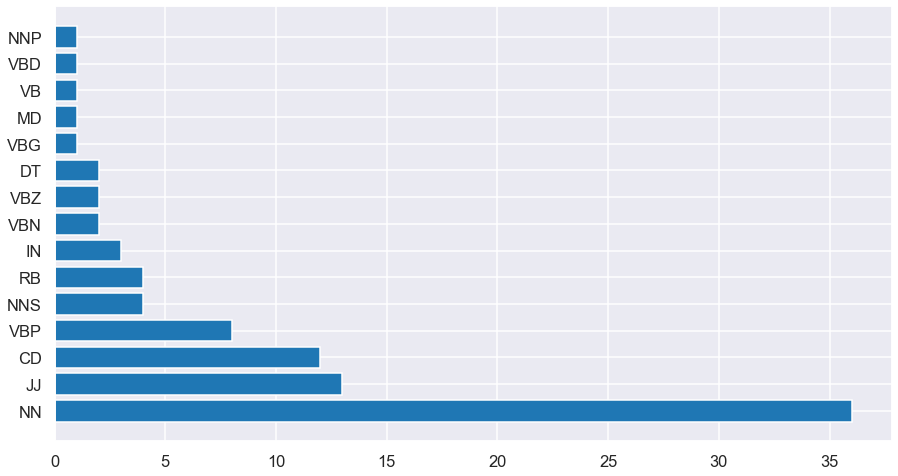

In [40]:
# Plotting the frequency of words by part-of-speech
blob = TextBlob(str(cafe_clean['joined_tokens']))
pos_df = pd.DataFrame(blob.tags, columns = ['word' , 'pos'])
pos_df = pos_df.pos.value_counts()[:20]
plt.figure(figsize=(15,8))
plt.barh(pos_df.index, pos_df.values);

---

Option to save clean dataframe

In [41]:
# Uncomment below to save clean dataframe to CSV in data folder
# cafe_clean.to_csv('./data/cafe_clean.csv')

## Baseline Modeling

There will be 4 sections of modeling:

1. Multiclass
2. Multiclass balanced classes using undersampling
3. Binary
4. Binary balanced classes using undersampling

In [63]:
# Option to read in clean DataFrame — uncomment below

cafe_clean = pd.read_csv('./data/cafe_clean.csv')
cafe_clean = cafe_clean.dropna()

In [65]:
# Creating Dictionary of Baseline Classifiers for an interative model fitting approach
baseline_models_mc = {'SGDClassifier': SGDClassifier(class_weight='balanced', random_state=SEED, loss="modified_huber"),

                  'LogisticRegression': LogisticRegression(n_jobs=1, C=.001, multi_class='multinomial', solver='saga', max_iter=500),

                  'NaiveBayes': MultinomialNB(),
               
                  'KNN': KNeighborsClassifier(n_neighbors=16),
               
                  'RandomForest': RandomForestClassifier(max_depth=8, random_state=SEED)
               }

In [66]:
# Reviewing each classifier
for clf in baseline_models_mc:
    print(baseline_models_mc[clf])

SGDClassifier(class_weight='balanced', loss='modified_huber',
              random_state=53188535)
LogisticRegression(C=0.001, max_iter=500, multi_class='multinomial', n_jobs=1,
                   solver='saga')
MultinomialNB()
KNeighborsClassifier(n_neighbors=16)
RandomForestClassifier(max_depth=8, random_state=53188535)


In [67]:
# Creating empty metric table to append model scoring
models_table = pd.DataFrame(columns=['Model', 'Target', 'CVScore', 'TestAcc'])

In [68]:
# Instantiating run_models class from nlp.py 
# This class contains the function to fit and predict the dictionary of classifiers
rm = run_models()

In [69]:
# Fitting and predicting multiclass models using BOW vectorization
multiclass_cv = rm.run(cafe_clean, 'joined_tokens', ['type'], baseline_models_mc, models_table, tfidf=False, SEED=SEED)
multiclass_cv

--------------------
type, target balance: 
infp    0.211068
infj    0.169408
intp    0.150346
intj    0.125749
entp    0.079016
enfp    0.077786
istp    0.038893
isfp    0.031207
entj    0.026595
istj    0.023674
enfj    0.021829
isfj    0.019216
estp    0.010300
esfp    0.005534
esfj    0.004919
estj    0.004458
Name: type, dtype: float64
Vectorizing....  @ Thu Mar 10 15:34:13 2022
Working on SGDClassifier for type @ Thu Mar 10 15:34:23 2022
Working on LogisticRegression for type @ Thu Mar 10 15:34:32 2022
Working on NaiveBayes for type @ Thu Mar 10 15:35:14 2022
Working on KNN for type @ Thu Mar 10 15:35:15 2022
Working on RandomForest for type @ Thu Mar 10 15:35:22 2022


,Model,Target,CVScore,TestAcc
0,SGDClassifier_type,type,0.3242,0.3255
1,LogisticRegression_type,type,0.3648,0.3877
2,NaiveBayes_type,type,0.3562,0.3790
3,KNN_type,type,0.2118,0.2213
4,RandomForest_type,type,0.2475,0.2430


In [70]:
# Fitting and predicting multiclass models using TF-IDF vectorization
multiclass_tfidf = rm.run(cafe_clean, 'joined_tokens', ['type'], baseline_models_mc, models_table, tfidf=True, SEED=SEED)
multiclass_tfidf

--------------------
type, target balance: 
infp    0.211068
infj    0.169408
intp    0.150346
intj    0.125749
entp    0.079016
enfp    0.077786
istp    0.038893
isfp    0.031207
entj    0.026595
istj    0.023674
enfj    0.021829
isfj    0.019216
estp    0.010300
esfp    0.005534
esfj    0.004919
estj    0.004458
Name: type, dtype: float64
Vectorizing....  @ Thu Mar 10 15:35:38 2022
Working on SGDClassifier for type @ Thu Mar 10 15:35:48 2022
Working on LogisticRegression for type @ Thu Mar 10 15:35:52 2022
Working on NaiveBayes for type @ Thu Mar 10 15:36:41 2022
Working on KNN for type @ Thu Mar 10 15:36:41 2022
Working on RandomForest for type @ Thu Mar 10 15:36:50 2022


,Model,Target,CVScore,TestAcc
0,SGDClassifier_type,type,0.3596,0.3831
1,LogisticRegression_type,type,0.2111,0.2112
2,NaiveBayes_type,type,0.2575,0.2725
3,KNN_type,type,0.2486,0.2471
4,RandomForest_type,type,0.2498,0.2582


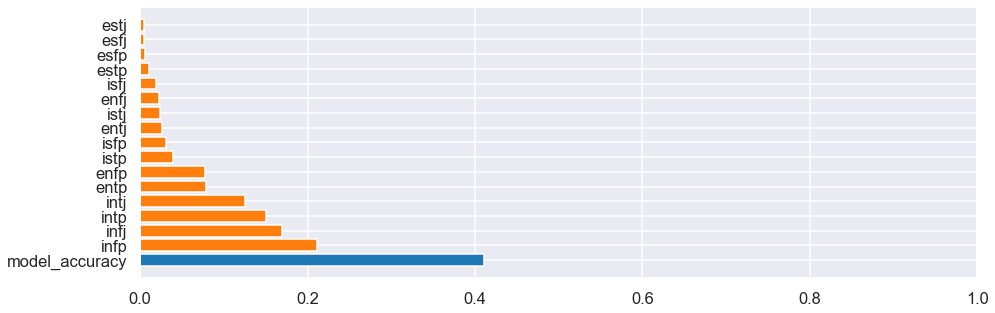

In [71]:
# Plotting the Model accuracy compared to the majority class
plt.figure(figsize=(15,5))
plt.barh('model_accuracy', .4108)
plt.barh(cafe_clean['type'].value_counts(normalize=True).index, cafe_clean['type'].value_counts(normalize=True).values)
plt.xlim(0, 1);

#### Multiclass Models Results
The largest class is `infp` of 21%. The models are not performing at a useful level, however there is reason to believe that the models are finding some distinction in word usage between the different MBTI types.

---

In [72]:
# Fitting and predicting multiclass models using BOW vectorization and Random Undersampling to balance classes
multiclass_rus_cv = rm.run_usampled(cafe_clean, 'joined_tokens', ['type'], baseline_models_mc, models_table, tfidf=False, SEED=234)
multiclass_rus_cv

Train: (array(['enfj', 'enfp', 'entj', 'entp', 'esfj', 'esfp', 'estj', 'estp',
       'infj', 'infp', 'intj', 'intp', 'isfj', 'isfp', 'istj', 'istp'],
      dtype=object), array([ 142,  506,  173,  514,   32,   36,   29,   67, 1102, 1373,  818,
        978,  125,  203,  154,  253]))
Train: (array(['enfj', 'enfp', 'entj', 'entp', 'esfj', 'esfp', 'estj', 'estp',
       'infj', 'infp', 'intj', 'intp', 'isfj', 'isfp', 'istj', 'istp'],
      dtype=object), array([29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29]))
Test: (array(['enfj', 'enfp', 'entj', 'entp', 'esfj', 'esfp', 'estj', 'estp',
       'infj', 'infp', 'intj', 'intp', 'isfj', 'isfp', 'istj', 'istp'],
      dtype=object), array([ 48, 169,  58, 171,  10,  12,  10,  22, 368, 458, 273, 326,  41,
        68,  51,  84]))
Test: (array(['enfj', 'enfp', 'entj', 'entp', 'esfj', 'esfp', 'estj', 'estp',
       'infj', 'infp', 'intj', 'intp', 'isfj', 'isfp', 'istj', 'istp'],
      dtype=object), array([10, 10, 10, 10, 10, 10, 10

,Model,Target,CVScore,TestAcc
0,SGDClassifier_type,type,0.0841,0.1125
1,LogisticRegression_type,type,0.1379,0.1438
2,NaiveBayes_type,type,0.1422,0.1812
3,KNN_type,type,0.0904,0.0750
4,RandomForest_type,type,0.1121,0.1312


In [73]:
# Fitting and predicting multiclass models using TF-IDF vectorization and Random Undersampling to balance classes
multiclass_rus_tfidf = rm.run_usampled(cafe_clean, 'joined_tokens', ['type'], baseline_models_mc, models_table, tfidf=True, SEED=234)
multiclass_rus_tfidf

Train: (array(['enfj', 'enfp', 'entj', 'entp', 'esfj', 'esfp', 'estj', 'estp',
       'infj', 'infp', 'intj', 'intp', 'isfj', 'isfp', 'istj', 'istp'],
      dtype=object), array([ 142,  506,  173,  514,   32,   36,   29,   67, 1102, 1373,  818,
        978,  125,  203,  154,  253]))
Train: (array(['enfj', 'enfp', 'entj', 'entp', 'esfj', 'esfp', 'estj', 'estp',
       'infj', 'infp', 'intj', 'intp', 'isfj', 'isfp', 'istj', 'istp'],
      dtype=object), array([29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29]))
Test: (array(['enfj', 'enfp', 'entj', 'entp', 'esfj', 'esfp', 'estj', 'estp',
       'infj', 'infp', 'intj', 'intp', 'isfj', 'isfp', 'istj', 'istp'],
      dtype=object), array([ 48, 169,  58, 171,  10,  12,  10,  22, 368, 458, 273, 326,  41,
        68,  51,  84]))
Test: (array(['enfj', 'enfp', 'entj', 'entp', 'esfj', 'esfp', 'estj', 'estp',
       'infj', 'infp', 'intj', 'intp', 'isfj', 'isfp', 'istj', 'istp'],
      dtype=object), array([10, 10, 10, 10, 10, 10, 10

,Model,Target,CVScore,TestAcc
0,SGDClassifier_type,type,0.0970,0.1375
1,LogisticRegression_type,type,0.0603,0.1250
2,NaiveBayes_type,type,0.1250,0.1812
3,KNN_type,type,0.0992,0.1188
4,RandomForest_type,type,0.1013,0.0812


(0.0, 1.0)

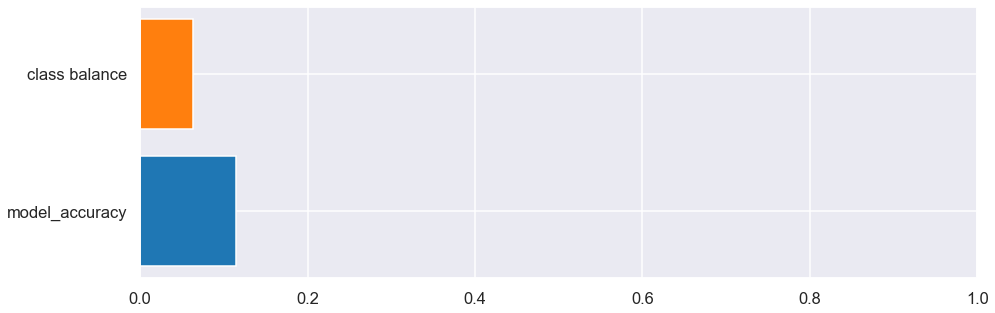

In [74]:
# Plotting the Model accuracy compared to the majority class (Random UnderSampled)
plt.figure(figsize=(15,5))
plt.barh('model_accuracy', .1143)
plt.barh('class balance', 1/16)
plt.xlim(0, 1)

In [75]:
# Concatenating final metric table of multiclass modeling

multiclass_cv['other'] = 'countvec'
multiclass_tfidf['other'] = 'tfidf'
multiclass_rus_cv['other'] = 'rus_countvec'
multiclass_rus_tfidf['other'] = 'rus_tfidf'


base_mc = pd.concat([multiclass_cv, multiclass_tfidf, multiclass_rus_cv, multiclass_rus_tfidf])
base_mc

,Model,Target,CVScore,TestAcc,other
0,SGDClassifier_type,type,0.3242,0.3255,countvec
1,LogisticRegression_type,type,0.3648,0.3877,countvec
2,NaiveBayes_type,type,0.3562,0.3790,countvec
3,KNN_type,type,0.2118,0.2213,countvec
4,RandomForest_type,type,0.2475,0.2430,countvec
0,SGDClassifier_type,type,0.3596,0.3831,tfidf
1,LogisticRegression_type,type,0.2111,0.2112,tfidf
2,NaiveBayes_type,type,0.2575,0.2725,tfidf
3,KNN_type,type,0.2486,0.2471,tfidf
4,RandomForest_type,type,0.2498,0.2582,tfidf


### Multiclass Undersampled Models Results
The largest class is `infp` of 21%. The models are not performing at a useful level, however there is reason to believe that the models are finding some distinction in word usage between the different MBTI types.

---

In [76]:
# Creating Dictionary of Baseline Classifiers for an interative model fitting approach
baseline_models_bin = {'SGDClassifier': SGDClassifier(class_weight='balanced', random_state=SEED, loss="modified_huber"),

                  'LogisticRegression': LogisticRegression(n_jobs=1, C=.001, max_iter=500),

                  'NaiveBayes': MultinomialNB(),
               
                  'KNN': KNeighborsClassifier(n_neighbors=2),
               
                  'RandomForest': RandomForestClassifier(max_depth=8, random_state=SEED)
               }

In [77]:
# Creating a list of the binary targets for interations
bin_targets = ['i/e', 'n/s', 't/f', 'p/j']
bin_targets

['i/e', 'n/s', 't/f', 'p/j']

In [78]:
# Fitting and predicting binary models using BOW vectorization
bin_cv = rm.run(cafe_clean, 'joined_tokens', bin_targets, baseline_models_bin, models_table, tfidf=False, SEED=SEED)
bin_cv

--------------------
i/e, target balance: 
i    0.769562
e    0.230438
Name: i/e, dtype: float64
Vectorizing....  @ Thu Mar 10 15:37:33 2022
Working on SGDClassifier for i/e @ Thu Mar 10 15:37:44 2022
Working on LogisticRegression for i/e @ Thu Mar 10 15:37:46 2022
Working on NaiveBayes for i/e @ Thu Mar 10 15:37:54 2022
Working on KNN for i/e @ Thu Mar 10 15:37:55 2022
Working on RandomForest for i/e @ Thu Mar 10 15:38:03 2022
--------------------
n/s, target balance: 
n    0.861952
s    0.138048
Name: n/s, dtype: float64
Vectorizing....  @ Thu Mar 10 15:38:07 2022
Working on SGDClassifier for n/s @ Thu Mar 10 15:38:19 2022
Working on LogisticRegression for n/s @ Thu Mar 10 15:38:20 2022
Working on NaiveBayes for n/s @ Thu Mar 10 15:38:23 2022
Working on KNN for n/s @ Thu Mar 10 15:38:23 2022
Working on RandomForest for n/s @ Thu Mar 10 15:38:31 2022
--------------------
t/f, target balance: 
f    0.540968
t    0.459032
Name: t/f, dtype: float64
Vectorizing....  @ Thu Mar 10 15:38:35 

,Model,Target,CVScore,TestAcc
0,SGDClassifier_i/e,i/e,0.7264,0.7418
1,LogisticRegression_i/e,i/e,0.7794,0.7824
2,NaiveBayes_i/e,i/e,0.7348,0.7340
3,KNN_i/e,i/e,0.6031,0.5970
4,RandomForest_i/e,i/e,0.7696,0.7695
5,SGDClassifier_n/s,n/s,0.8357,0.8303
6,LogisticRegression_n/s,n/s,0.8632,0.8631
7,NaiveBayes_n/s,n/s,0.8303,0.8276
8,KNN_n/s,n/s,0.8264,0.8373
9,RandomForest_n/s,n/s,0.8620,0.8621


In [79]:
# Fitting and predicting multiclass models using TF-IDF vectorization
bin_tfidf = rm.run(cafe_clean, 'joined_tokens', bin_targets, baseline_models_bin, models_table, tfidf=True, SEED=SEED)
bin_tfidf

--------------------
i/e, target balance: 
i    0.769562
e    0.230438
Name: i/e, dtype: float64
Vectorizing....  @ Thu Mar 10 15:40:04 2022
Working on SGDClassifier for i/e @ Thu Mar 10 15:40:21 2022
Working on LogisticRegression for i/e @ Thu Mar 10 15:40:22 2022
Working on NaiveBayes for i/e @ Thu Mar 10 15:40:22 2022
Working on KNN for i/e @ Thu Mar 10 15:40:23 2022
Working on RandomForest for i/e @ Thu Mar 10 15:40:35 2022
--------------------
n/s, target balance: 
n    0.861952
s    0.138048
Name: n/s, dtype: float64
Vectorizing....  @ Thu Mar 10 15:40:46 2022
Working on SGDClassifier for n/s @ Thu Mar 10 15:41:00 2022
Working on LogisticRegression for n/s @ Thu Mar 10 15:41:01 2022
Working on NaiveBayes for n/s @ Thu Mar 10 15:41:03 2022
Working on KNN for n/s @ Thu Mar 10 15:41:03 2022
Working on RandomForest for n/s @ Thu Mar 10 15:41:12 2022
--------------------
t/f, target balance: 
f    0.540968
t    0.459032
Name: t/f, dtype: float64
Vectorizing....  @ Thu Mar 10 15:41:20 

,Model,Target,CVScore,TestAcc
0,SGDClassifier_i/e,i/e,0.7437,0.7298
1,LogisticRegression_i/e,i/e,0.7696,0.7695
2,NaiveBayes_i/e,i/e,0.7696,0.7695
3,KNN_i/e,i/e,0.5789,0.5726
4,RandomForest_i/e,i/e,0.7696,0.7695
5,SGDClassifier_n/s,n/s,0.8304,0.8091
6,LogisticRegression_n/s,n/s,0.8620,0.8621
7,NaiveBayes_n/s,n/s,0.8620,0.8621
8,KNN_n/s,n/s,0.8457,0.8479
9,RandomForest_n/s,n/s,0.8620,0.8621


Accuracy increase from class balance in i/e is: 0.01
Accuracy increase from class balance in n/s is: -0.01
Accuracy increase from class balance in t/f is: 0.25
Accuracy increase from class balance in p/j is: 0.08


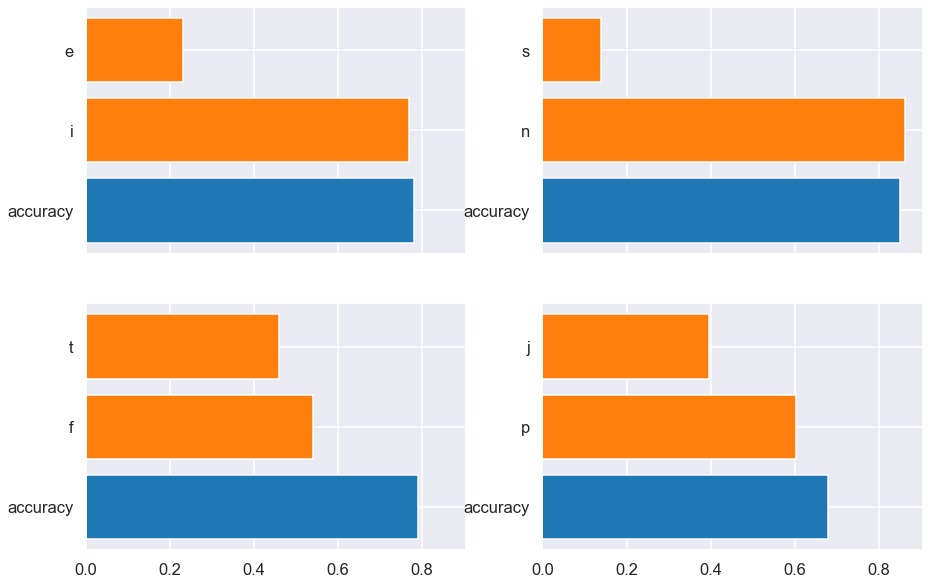

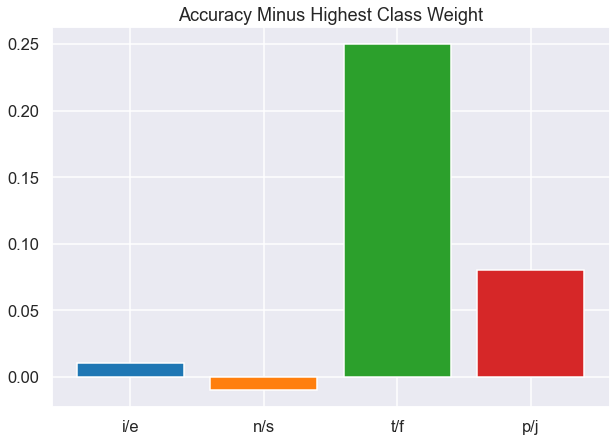

In [80]:
# Plotting the Model accuracy compared to the majority class
fig, axs = plt.subplots(2, 2, figsize=(15,10), sharex=True)
axs[0, 0].barh('accuracy', .78)
axs[0, 0].barh(cafe_clean['i/e'].value_counts(normalize=True).index, cafe_clean['i/e'].value_counts(normalize=True).values)

axs[0,1].barh('accuracy', .85)
axs[0,1].barh(cafe_clean['n/s'].value_counts(normalize=True).index, cafe_clean['n/s'].value_counts(normalize=True).values)

axs[1,0].barh('accuracy', .79)
axs[1,0].barh(cafe_clean['t/f'].value_counts(normalize=True).index, cafe_clean['t/f'].value_counts(normalize=True).values)

axs[1,1].barh('accuracy', .68)
axs[1,1].barh(cafe_clean['p/j'].value_counts(normalize=True).index, cafe_clean['p/j'].value_counts(normalize=True).values)

acc = [.78, .85, .79, .68]
plt.figure(figsize=(10,7))
plt.title('Accuracy Minus Highest Class Weight')
for i, target in enumerate(bin_targets):
    increase = round(acc[i] - cafe_clean[target].value_counts(normalize=True)[0], 2)
    print(f'Accuracy increase from class balance in {target} is: {increase}')
    plt.bar(target, increase)
plt.show();


#### Binary Models Results
The largest class is `infp` of 21%. The models are not performing at a useful level, however there is reason to believe that the models are finding some distinction in word usage between the different MBTI types.

---

In [81]:
# Fitting and predicting multiclass models using BOW vectorization and Random Undersampling to balance classes
bin_rus_cv = rm.run_usampled(cafe_clean, 'joined_tokens', bin_targets, baseline_models_bin, models_table, tfidf=False, SEED=SEED)
bin_rus_cv

Train: (array(['e', 'i'], dtype=object), array([1499, 5006]))
Train: (array(['e', 'i'], dtype=object), array([1499, 1499]))
Test: (array(['e', 'i'], dtype=object), array([ 500, 1669]))
Test: (array(['e', 'i'], dtype=object), array([500, 500]))
Vectorizing....  @ Thu Mar 10 15:42:35 2022
Working on SGDClassifier @ Thu Mar 10 15:42:40 2022
Working on LogisticRegression @ Thu Mar 10 15:42:40 2022
Working on NaiveBayes @ Thu Mar 10 15:42:42 2022
Working on KNN @ Thu Mar 10 15:42:42 2022
Working on RandomForest @ Thu Mar 10 15:42:43 2022
Train: (array(['n', 's'], dtype=object), array([5607,  898]))
Train: (array(['n', 's'], dtype=object), array([898, 898]))
Test: (array(['n', 's'], dtype=object), array([1870,  299]))
Test: (array(['n', 's'], dtype=object), array([299, 299]))
Vectorizing....  @ Thu Mar 10 15:42:47 2022
Working on SGDClassifier @ Thu Mar 10 15:42:50 2022
Working on LogisticRegression @ Thu Mar 10 15:42:50 2022
Working on NaiveBayes @ Thu Mar 10 15:42:50 2022
Working on KNN @ 

,Model,Target,CVScore,TestAcc
0,SGDClassifier_i/e,i/e,0.6231,0.6440
1,LogisticRegression_i/e,i/e,0.6638,0.6590
2,NaiveBayes_i/e,i/e,0.6784,0.6730
3,KNN_i/e,i/e,0.5290,0.5220
4,RandomForest_i/e,i/e,0.6341,0.6290
5,SGDClassifier_n/s,n/s,0.6225,0.6388
6,LogisticRegression_n/s,n/s,0.6598,0.6806
7,NaiveBayes_n/s,n/s,0.6743,0.6856
8,KNN_n/s,n/s,0.5551,0.5468
9,RandomForest_n/s,n/s,0.6136,0.6488


In [82]:
# Fitting and predicting multiclass models using TF-IDF vectorization and Random Undersampling to balance classes
bin_rus_tfidf = rm.run_usampled(cafe_clean, 'joined_tokens', bin_targets, baseline_models_bin, models_table, tfidf=True, SEED=SEED)
bin_rus_tfidf

Train: (array(['e', 'i'], dtype=object), array([1499, 5006]))
Train: (array(['e', 'i'], dtype=object), array([1499, 1499]))
Test: (array(['e', 'i'], dtype=object), array([ 500, 1669]))
Test: (array(['e', 'i'], dtype=object), array([500, 500]))
Vectorizing....  @ Thu Mar 10 15:43:46 2022
Working on SGDClassifier @ Thu Mar 10 15:43:51 2022
Working on LogisticRegression @ Thu Mar 10 15:43:51 2022
Working on NaiveBayes @ Thu Mar 10 15:43:51 2022
Working on KNN @ Thu Mar 10 15:43:51 2022
Working on RandomForest @ Thu Mar 10 15:43:53 2022
Train: (array(['n', 's'], dtype=object), array([5607,  898]))
Train: (array(['n', 's'], dtype=object), array([898, 898]))
Test: (array(['n', 's'], dtype=object), array([1870,  299]))
Test: (array(['n', 's'], dtype=object), array([299, 299]))
Vectorizing....  @ Thu Mar 10 15:43:58 2022
Working on SGDClassifier @ Thu Mar 10 15:44:01 2022
Working on LogisticRegression @ Thu Mar 10 15:44:01 2022
Working on NaiveBayes @ Thu Mar 10 15:44:01 2022
Working on KNN @ 

,Model,Target,CVScore,TestAcc
0,SGDClassifier_i/e,i/e,0.6354,0.6330
1,LogisticRegression_i/e,i/e,0.6548,0.6600
2,NaiveBayes_i/e,i/e,0.6808,0.6640
3,KNN_i/e,i/e,0.5440,0.5290
4,RandomForest_i/e,i/e,0.6414,0.6200
5,SGDClassifier_n/s,n/s,0.6303,0.6288
6,LogisticRegression_n/s,n/s,0.5879,0.7107
7,NaiveBayes_n/s,n/s,0.6681,0.7090
8,KNN_n/s,n/s,0.5618,0.5552
9,RandomForest_n/s,n/s,0.6186,0.6522


Accuracy increase from class balance in i/e is: 0.18
Accuracy increase from class balance in n/s is: 0.23
Accuracy increase from class balance in t/f is: 0.3
Accuracy increase from class balance in p/j is: 0.16


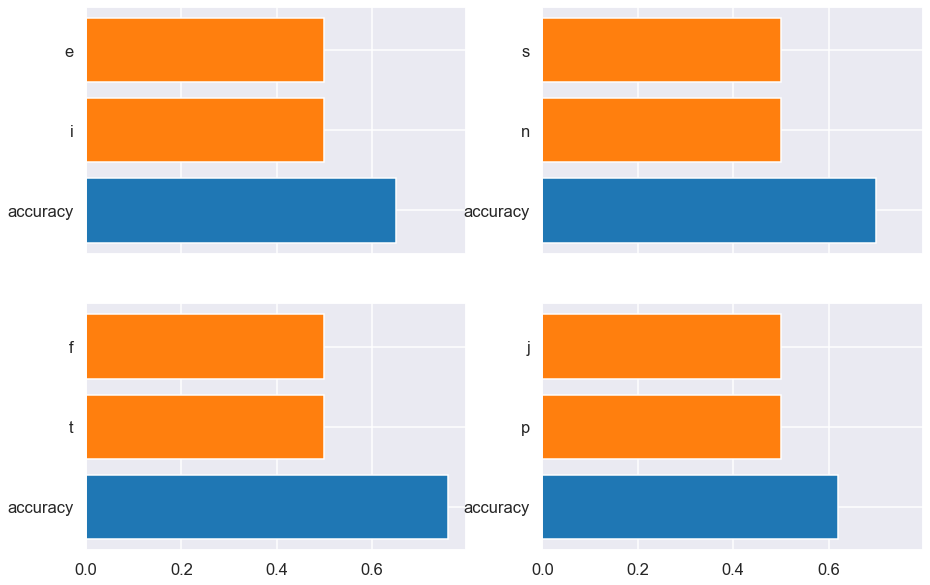

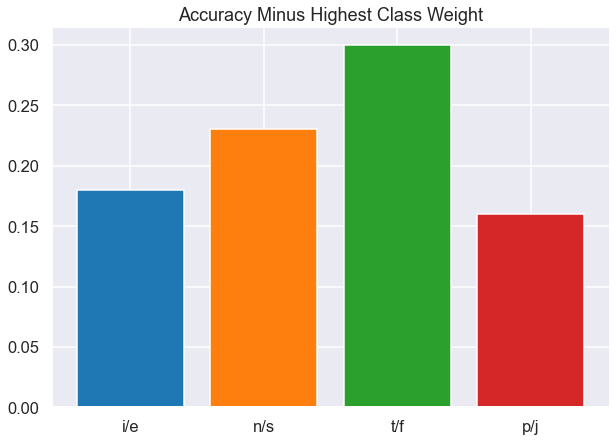

In [83]:
# Plotting the Model accuracy compared to the majority class (Random UnderSampled)
fig, axs = plt.subplots(2, 2, figsize=(15,10), sharex=True)
axs[0, 0].barh('accuracy', .65)
axs[0, 0].barh(['i', 'e'], [.5, .5])

axs[0,1].barh('accuracy', .70)
axs[0,1].barh(['n', 's'], [.5, .5])

axs[1,0].barh('accuracy', .76)
axs[1, 0].barh(['t', 'f'], [.5, .5])

axs[1,1].barh('accuracy', .62)
axs[1,1].barh(['p', 'j'], [.5, .5])

acc = [.68, .73, .8, .66]
plt.figure(figsize=(10,7))
plt.title('Accuracy Minus Highest Class Weight')
for i, target in enumerate(bin_targets):
    print(f'Accuracy increase from class balance in {target} is: {round(acc[i] - .5, 2)}')
    plt.bar(target, round(acc[i] - .5, 2))


In [84]:
# Probability we are seeing these results given a 50/50 class balance

print(f"Prob of i/e model: {1 - binom.cdf(k=(1499*2)*.65, n=1499*2, p=0.5)}")
print(f"Prob of n/s model: {1 - binom.cdf(k=(898*2)*.70, n=(898*2), p=0.5)}")
print(f"Prob of t/f model: {1 - binom.cdf(k=(1499*2)*.76, n=1499*2, p=0.5)}")
print(f"Prob of p/j model: {1 - binom.cdf(k=(2575*2)*.62, n=2575*2, p=0.5)}")

Prob of i/e model: 0.0
Prob of n/s model: 0.0
Prob of t/f model: 0.0
Prob of p/j model: 0.0


#### Binary Undersampled Model Results
The largest class is `infp` of 21%. The models are not performing at a useful level, however there is reason to believe that the models are finding some distinction in word usage between the different MBTI types.

---

## Doc2Vec
1. Multiclass
2. Thinking vs. Feeling

In [85]:
# Option to read in clean DataFrame — uncomment below

# cafe_clean = pd.read_csv('./data/cafe_clean.csv')
# cafe_clean = cafe_clean.dropna()

In [86]:
# Splitting into testing and training sets
train_df, test_df = train_test_split(cafe_clean, random_state=SEED)

In [87]:
# Reseting index for iteration pruposes
train_df.reset_index(inplace=True, drop=True)
test_df.reset_index(inplace=True, drop=True)

#### Multiclass

In [88]:
# Multiclass generation of train / test corpus tagged with MBTI types
def tokenize_gens(dataframe):
    for i, post in enumerate(dataframe['joined_tokens']):
        tokens = gensim.utils.simple_preprocess(post)
        yield gensim.models.doc2vec.TaggedDocument(tokens, dataframe.loc[i, 'type'])

train_corpus = list(tokenize_gens(train_df))
test_corpus = list(tokenize_gens(test_df))

In [89]:
# Creating the Doc2Vec model
model = gensim.models.doc2vec.Doc2Vec(dm=1, 
                                    vector_size=50, 
                                    min_count=2, 
                                    epochs=40)

In [90]:
# Building the vocabulary 
model.build_vocab(train_corpus)

In [91]:
# Training the model
model.train(train_corpus, total_examples=model.corpus_count, epochs=model.epochs)

In [92]:
# Showing how the model infers collections of words into vectors
vector = model.infer_vector(['unaware', 'people', 'dont', 'confidence', 'often', 'picture'])
print(vector)

[ 0.04769732 -0.6609382   0.32225087 -0.02495661  0.36097336 -0.23037073
  0.0613782   0.43190825  0.210913   -0.07444087  0.19161163 -0.00161645
 -0.04842895  0.36415902  0.0465914   0.29311714 -0.03189124  0.31414035
 -0.11606619  0.44401804 -0.18575634  0.21282396 -0.6112931   0.20925616
  0.04770497  0.05479902 -0.0255067  -0.55341685 -0.4663434   0.23070508
  0.04337824  0.2384341  -0.63851607  0.30550817 -0.14682952  0.06701313
  0.55515766 -0.05368286  0.15707268 -0.26785338  0.0815747   0.42829624
  0.44756117  0.4034293   0.10612673  0.27105606 -0.14230138  0.13442615
  0.22814877 -0.03568159]


In [93]:
# Creating a function that returns targets and vectors — to be applied to each of the posts
def vector_for_learning(model, posts):
    targets, feature_vectors = zip(*[(doc.tags, model.infer_vector(doc.words)) for doc in posts])
    return targets, feature_vectors

In [94]:
# Splitting the train and test set into targets and X vectors
# Can take a few minutes
y_train, X_train = vector_for_learning(model, train_corpus)
y_test, X_test = vector_for_learning(model, test_corpus)

In [95]:
# Modeling with an SGD Classifier
clf = SGDClassifier(class_weight='balanced')
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
print(f'Testing accuracy: {accuracy_score(y_test, y_pred)}')

Testing accuracy: 0.24573536191793452


In [96]:
# Modeling with an Logistic Regression
logreg = LogisticRegression(n_jobs=1, C=.0001, class_weight='balanced')
logreg.fit(X_train, y_train)
y_pred = logreg.predict(X_test)
print(f'Testing accuracy: {accuracy_score(y_test, y_pred)}')

Testing accuracy: 0.32180728446288615


In [97]:
# Modeling with Random Forest
rfc = RandomForestClassifier(n_estimators=1000, max_depth=25)
rfc.fit(X_train, y_train)
y_pred = rfc.predict(X_test)
print(f'Testing accuracy: {accuracy_score(y_test, y_pred)}')

Testing accuracy: 0.34163208852005533


In [98]:
# Modeling with KNN
knn = KNeighborsClassifier(n_neighbors=16)
knn.fit(X_train, y_train)
y_pred = knn.predict(X_test)
print(f'Testing accuracy: {accuracy_score(y_test, y_pred)}')

Testing accuracy: 0.3075149838635316


#### Thinking vs. Feeling
Looking exclusively at Thinking vs. Feeling binary class because it showed the most significant icnreases in accuracy scores using BOW and TF-IDF vectorization strategies.

In [99]:
# Binary class t/f generation of train / test corpus tagged with MBTI types
def tokenize_gens(dataframe):
    for i, post in enumerate(dataframe['joined_tokens']):
        tokens = gensim.utils.simple_preprocess(post)
        yield gensim.models.doc2vec.TaggedDocument(tokens, dataframe.loc[i, 't/f'])

train_corpus = list(tokenize_gens(train_df))
test_corpus = list(tokenize_gens(test_df))

In [100]:
# Creating the Doc2Vec model
model = gensim.models.doc2vec.Doc2Vec(dm=1, 
                                    vector_size=50, 
                                    min_count=2, 
                                    epochs=40)

In [101]:
# Building the vocabulary 
model.build_vocab(train_corpus)

In [102]:
# Training the model
model.train(train_corpus, total_examples=model.corpus_count, epochs=model.epochs)

In [103]:
# Splitting the train and test set into targets and X vectors
# Can take a few minutes
y_train, X_train = vector_for_learning(model, train_corpus)
y_test, X_test = vector_for_learning(model, test_corpus)

In [104]:
# Modeling with an SGD Classifier
clf2 = SGDClassifier(class_weight='balanced')
clf2.fit(X_train, y_train)
y_pred = clf2.predict(X_test)
print(f'Testing accuracy: {accuracy_score(y_test, y_pred)}')

Testing accuracy: 0.7722452743199631


In [105]:
# Modeling with an Logistic Regression
logreg2 = LogisticRegression(n_jobs=1, C=.0001, class_weight='balanced')
logreg2.fit(X_train, y_train)
y_pred = logreg2.predict(X_test)
print(f'Testing accuracy: {accuracy_score(y_test, y_pred)}')

Testing accuracy: 0.8049792531120332


In [106]:
# Modeling with Random Forest
rfc2 = RandomForestClassifier(n_estimators=1000, max_depth=25)
rfc2.fit(X_train, y_train)
y_pred = rfc2.predict(X_test)
print(f'Testing accuracy: {accuracy_score(y_test, y_pred)}')

Testing accuracy: 0.7856154910096819


In [107]:
# Modeling with KNN
knn2 = KNeighborsClassifier(n_neighbors=2)
knn2.fit(X_train, y_train)
y_pred = knn2.predict(X_test)
print(f'Testing accuracy: {accuracy_score(y_test, y_pred)}')

Testing accuracy: 0.6855693868142001


## Model Tuning

In [108]:
# Option to read in clean DataFrame — uncomment below

# cafe_clean = pd.read_csv('./data/cafe_clean.csv')
# cafe_clean = cafe_clean.dropna()

In [109]:
# Here is where manual tuning can be done by altering the hyperparameters of the Vectorizer and Classifier
pipe = Pipeline([('vec', TfidfVectorizer(ngram_range=(1,2))),
    ('clf', SGDClassifier(class_weight='balanced', random_state=SEED, loss="modified_huber"))
])

              precision    recall  f1-score   support

           i       0.54      0.23      0.32       435
           e       0.83      0.95      0.89      1734

    accuracy                           0.81      2169
   macro avg       0.68      0.59      0.60      2169
weighted avg       0.77      0.81      0.77      2169

              precision    recall  f1-score   support

           n       0.86      1.00      0.92      1854
           s       0.67      0.04      0.07       315

    accuracy                           0.86      2169
   macro avg       0.76      0.52      0.50      2169
weighted avg       0.83      0.86      0.80      2169

              precision    recall  f1-score   support

           f       0.81      0.83      0.82      1152
           t       0.80      0.78      0.79      1017

    accuracy                           0.80      2169
   macro avg       0.80      0.80      0.80      2169
weighted avg       0.80      0.80      0.80      2169

              preci

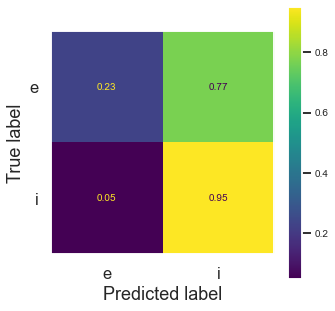

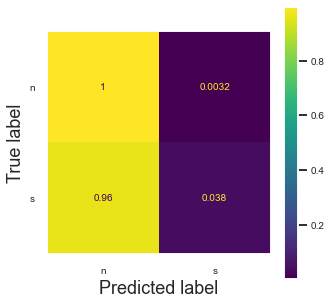

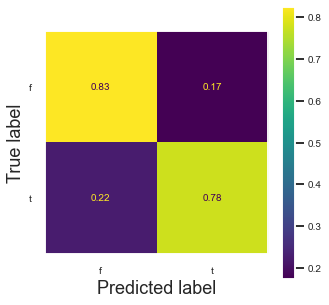

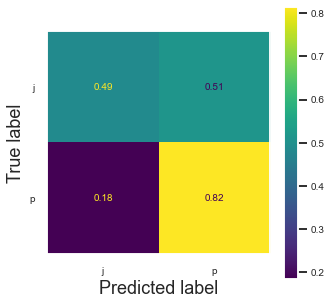

In [110]:
# Iterating through the binary classes and printing a full classification report along with confusion matrix
for target in bin_targets:
    X = cafe_clean['joined_tokens']
    y = cafe_clean[target]

    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=SEED)

    pipe.fit(X_train, y_train)

    y_pred = pipe.predict(X_test)
    acc_score = accuracy_score(y_pred, y_test)

    print(classification_report(y_pred=y_pred, y_true=y_test, target_names=cafe_clean[target].unique()))

    fig, ax = plt.subplots(figsize=(5,5))
    plt.rcParams.update({'font.size': 10})
    plt.rc('xtick', labelsize=10) 
    plt.rc('ytick', labelsize=10) 
    plot_confusion_matrix(pipe, X_test, y_test, ax=ax, normalize='true')
    plt.grid(False);
    

### Binary Modeling Takeaways:
- It seems that the T/F binary class is the only class that is able to discern itself given word usage and word choice
- The other 3 binary classes have poor F1-Scores and are often favoring their majority class. 
- For example, N/S seems high accuracy @ 86%, but when the label is truly S, the model predicts N 96% of the time

---

## Final Model

The final model choses is the binary classification of *THINKING* vs *FEEELING*

In [111]:
# Option to read in clean DataFrame — uncomment below

# cafe_clean = pd.read_csv('./data/cafe_clean.csv')
# cafe_clean = cafe_clean.dropna()

              precision    recall  f1-score   support

           f       0.80      0.81      0.81      1152
           t       0.78      0.78      0.78      1017

    accuracy                           0.79      2169
   macro avg       0.79      0.79      0.79      2169
weighted avg       0.79      0.79      0.79      2169



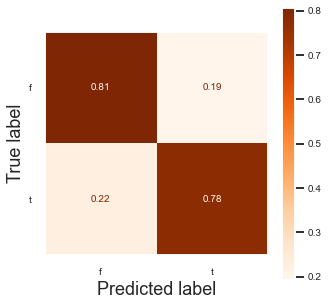

In [112]:
# Final Tuned Logistic Regression for the T/F class
final_logreg = Pipeline([('vec', TfidfVectorizer(ngram_range=(1,2), min_df=5)),
                ('clf', LogisticRegression(class_weight={'f': .46, 't': .54}, max_iter=1000))
            ])

X = cafe_clean['joined_tokens']
y = cafe_clean['t/f']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=SEED)

final_logreg.fit(X_train, y_train)

y_pred = final_logreg.predict(X_test)
acc_score = accuracy_score(y_test, y_pred)

print(classification_report(y_pred=y_pred, y_true=y_test, target_names=cafe_clean['t/f'].unique()))

fig, ax = plt.subplots(figsize=(5,5))
plt.rcParams.update({'font.size': 10})
plt.rc('xtick', labelsize=10) 
plt.rc('ytick', labelsize=10) 
plot_confusion_matrix(final_logreg, X_test, y_test, ax=ax, normalize='true', cmap='Oranges')
plt.grid(False);

              precision    recall  f1-score   support

           f       0.83      0.80      0.81      1152
           t       0.78      0.81      0.79      1017

    accuracy                           0.80      2169
   macro avg       0.80      0.80      0.80      2169
weighted avg       0.80      0.80      0.80      2169



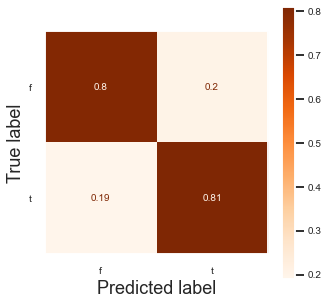

In [113]:
# Final Tuned SGD Classifier for the T/F class

final_sgd = Pipeline([('vec', TfidfVectorizer(ngram_range=(1,2), min_df=2)),
                ('clf', SGDClassifier(class_weight={'f': .45, 't': .55}, random_state=SEED, loss="modified_huber"))
            ])

X = cafe_clean['joined_tokens']
y = cafe_clean['t/f']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=SEED)

final_sgd.fit(X_train, y_train)

y_pred = final_sgd.predict(X_test)
acc_score = accuracy_score(y_test, y_pred)

print(classification_report(y_pred=y_pred, y_true=y_test, target_names=cafe_clean['t/f'].unique()))

fig, ax = plt.subplots(figsize=(5,5))
plt.rcParams.update({'font.size': 10})
plt.rc('xtick', labelsize=10) 
plt.rc('ytick', labelsize=10) 
plot_confusion_matrix(final_sgd, X_test, y_test, ax=ax, normalize='true', cmap='Oranges')
plt.grid(False);

In [114]:
# Uncomment below to save final model
# pickle.dump(final_sgd, open('./models/final_model.pkl', 'wb'))

## Further Inspect Thinking vs Feeling

### What does the Thinking vs. Feeling Trait mean?

**Thinking (T)**
When I make a decision, I like to find the basic truth or principle to be applied, regardless of the specific situation involved. I like to analyze pros and cons, and then be consistent and logical in deciding. I try to be impersonal, so I won't let my personal wishes--or other people's wishes--influence me.

The following statements generally apply to me:

- I enjoy technical and scientific fields where logic is important.
- I notice inconsistencies.
- I look for logical explanations or solutions to most everything.
- I make decisions with my head and want to be fair.
- I believe telling the truth is more important than being tactful.
- Sometimes I miss or don't value the "people" part of a situation.
- I can be seen as too task-oriented, uncaring, or indifferent.

**Feeling (F)**
I believe I can make the best decisions by weighing what people care about and the points-of-view of persons involved in a situation. I am concerned with values and what is the best for the people involved. I like to do whatever will establish or maintain harmony. In my relationships, I appear caring, warm, and tactful.

The following statements generally apply to me:

- I have a people or communications orientation.
- I am concerned with harmony and nervous when it is missing.
- I look for what is important to others and express concern for others.
- I make decisions with my heart and want to be compassionate.
- I believe being tactful is more important than telling the "cold" truth.
- Sometimes I miss seeing or communicating the "hard truth" of situations.
- I am sometimes experienced by others as too idealistic, mushy, or indirect.


In [115]:
# Creating Frequency Distributions of T and F seperately
t_fdist = FreqDist(cafe_clean["post_tokens"][cafe_clean["t/f"] == 't'].explode())
f_fdist = FreqDist(cafe_clean["post_tokens"][cafe_clean["t/f"] == 'f'].explode())

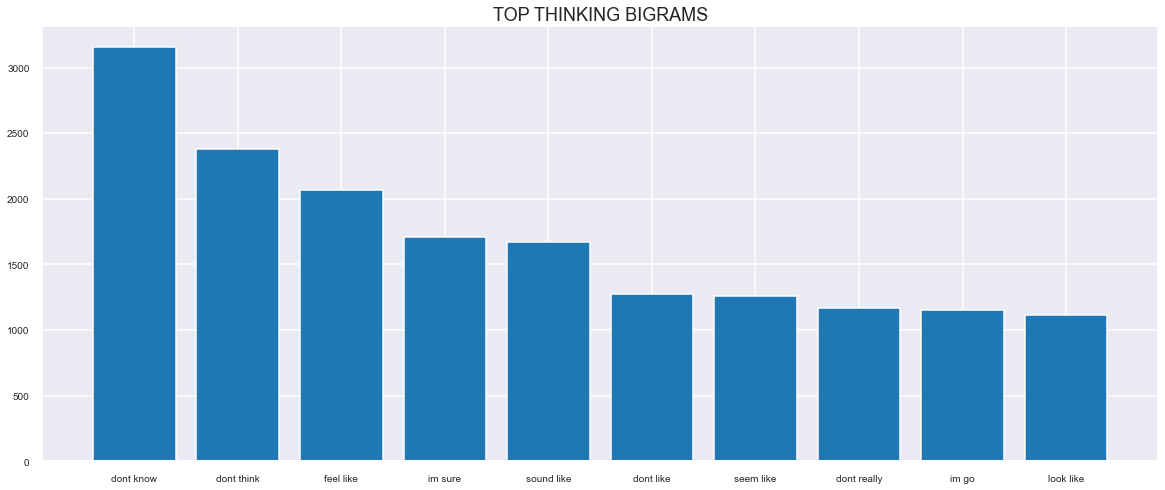

In [116]:
# Visualizing top THINKING bigrams
t_df = cafe_clean[cafe_clean["t/f"] == 't']

cv = CountVectorizer(ngram_range=(2,2))

tf_cv = cv.fit(t_df['joined_tokens'])
tf_cv = cv.transform(t_df['joined_tokens'])

count_values = tf_cv.toarray().sum(axis=0)

vocab = cv.vocabulary_

df_ngram = pd.DataFrame(sorted([(count_values[i], k) for k, i in vocab.items()], reverse=True) \
                        ).rename(columns={0: 'frequency', 1:'bigram'})

plt.figure(figsize=(20, 8))
plt.bar(df_ngram.bigram.iloc[:10], df_ngram.frequency.iloc[:10])
plt.title('TOP THINKING BIGRAMS');

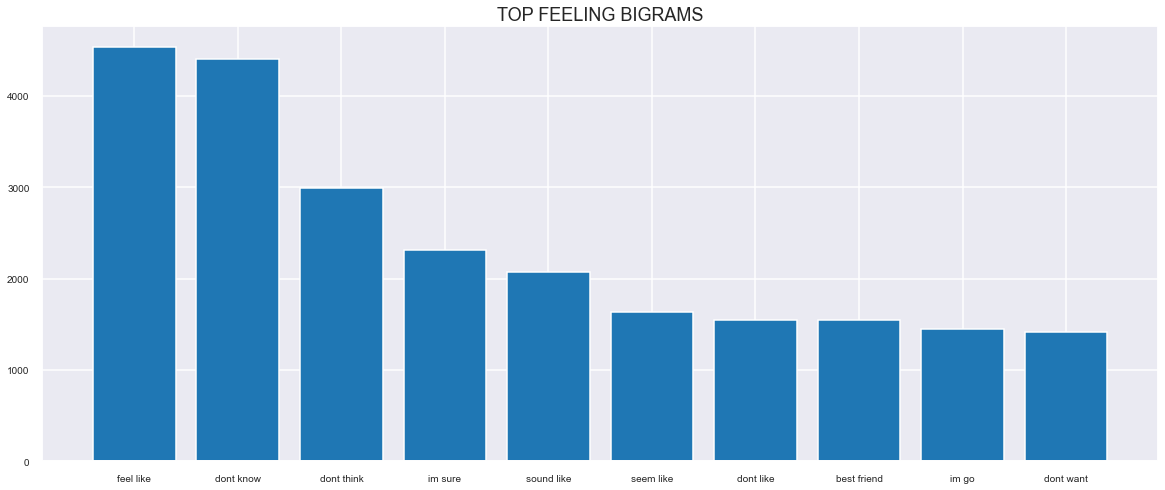

In [117]:
# Visualizing top FEELING bigrams

t_df = cafe_clean[cafe_clean["t/f"] == 'f']

cv = CountVectorizer(ngram_range=(2,2))

tf_cv = cv.fit(t_df['joined_tokens'])
tf_cv = cv.transform(t_df['joined_tokens'])

count_values = tf_cv.toarray().sum(axis=0)

vocab = cv.vocabulary_

df_ngram = pd.DataFrame(sorted([(count_values[i], k) for k, i in vocab.items()], reverse=True) \
                        ).rename(columns={0: 'frequency', 1:'bigram'})

plt.figure(figsize=(20, 8))
plt.bar(df_ngram.bigram.iloc[:10], df_ngram.frequency.iloc[:10])
plt.title('TOP FEELING BIGRAMS');

In [118]:
# Custom Sample Prediction
f_test_sample = "I love being in engaging conversation something that doesnt bore me something \
meaningful and makes both of you feel good. But sometimes I get called intense is this just me? \
Like I could say well sometimes you bore me. Seems like Im the minority so its \
really nice when I meet someone my vibe as there arent many"

print(final_sgd.predict([f_test_sample])[0], '--', f"{round(max(final_sgd.predict_proba([f_test_sample])[0])*100, 2)}%")

f -- 62.02%


In [119]:
# Custom Sample Prediction
t_test_sample = "Nature provides exceptions to every rule. But this rule is applied to itself paradoxically. \
(So there must be some rules without any exception :)"

print(final_sgd.predict([t_test_sample])[0], '--', f"{round(max(final_sgd.predict_proba([t_test_sample])[0])*100, 2)}%")

t -- 76.35%


### Highest TFIDF
Finding the Highest TF-IDF words and phrases in the corpus

In [120]:
# Splitting into train and test sets
train_set, test_set = train_test_split(cafe_clean, random_state=SEED)

In [121]:
# Splitting train set by T/F
X_train_t = train_set[train_set['t/f'] == 't']['joined_tokens']
X_train_f = train_set[train_set['t/f'] == 'f']['joined_tokens']

In [122]:
# THINKING Vectorizer
tfidf_t = TfidfVectorizer(ngram_range=(1,2), min_df=50)

train_tfidf_t = tfidf_t.fit_transform(X_train_t)
feature_array_t = np.array(tfidf_t.get_feature_names())

In [123]:
# FEELING Vectorizer
tfidf_f = TfidfVectorizer(ngram_range=(1,2), min_df=50)

train_tfidf_f = tfidf_f.fit_transform(X_train_f)
feature_array_f = np.array(tfidf_f.get_feature_names())

In [124]:
# Vectors to DataFrames
tfidf_df_t = pd.DataFrame(train_tfidf_t.toarray(), columns=tfidf_t.get_feature_names())
tfidf_df_f = pd.DataFrame(train_tfidf_f.toarray(), columns=tfidf_f.get_feature_names())

In [125]:
# Getting list of highest TF-IDF per post — Thinking
highest_tfidf_t = []
for column in tfidf_df_t.columns:
    highest_tfidf_t.append((column, tfidf_df_t[column].max()))

In [126]:
# Getting list of highest TF-IDF per post — Feeling
highest_tfidf_f = []
for column in tfidf_df_f.columns:
    highest_tfidf_f.append((column, tfidf_df_f[column].max()))

In [127]:
# Sorting by Highest TF-IDF
def getKey(item):
    return item[1]

high_tfidf_t = sorted(highest_tfidf_t, key=getKey, reverse=True)
high_tfidf_f = sorted(highest_tfidf_f, key=getKey, reverse=True)

In [128]:
# Viewing Results
high_tfidf_f[:10]

[('type likely', 0.8313310793219044),
 ('congrats', 0.8106021712197423),
 ('sir', 0.7703091773379824),
 ('grateful', 0.7597962125368377),
 ('flight', 0.7512881387570077),
 ('ugly', 0.7203540103400556),
 ('temperament', 0.7196939286650329),
 ('welcome', 0.7144088293416635),
 ('hug', 0.7054509085115117),
 ('welcome perc', 0.7047464575898609)]

In [129]:
# Viewing Results
high_tfidf_t[:10]

[('youtube', 0.8409272452680038),
 ('go go', 0.8283567614272469),
 ('type likely', 0.8012866431672608),
 ('ha', 0.7977459627582976),
 ('blush', 0.773445485643529),
 ('welcome forum', 0.7608722391535365),
 ('metal', 0.7422110586386929),
 ('kitteh', 0.7225445257558895),
 ('cool', 0.7214607333682072),
 ('ban', 0.6912907344379339)]

#### Creating testing sample and TF-IDF Vectorizer for the personality_predictor.py APP

In [130]:
# Using the index from y test
testing_df = cafe_clean.iloc[y_test.index]

In [131]:
# Concat X test variables
testing_set = pd.concat([y_test, X_test], axis=1)

In [132]:
# Sampling evenely from T/F
t_sample = testing_df[testing_df['t/f'] == 't'].sample(50, replace=False, random_state=SEED)
f_sample = testing_df[testing_df['t/f'] == 'f'].sample(50, replace=False, random_state=SEED)

testingsample_set = pd.concat([t_sample, f_sample], axis=0)

In [133]:
# Uncomment to save testing sample df to data folder
# testingsample_set.to_csv('./data/testingsample_df.csv')

In [134]:
# Reset index on test
X_test.reset_index(inplace=True, drop=True)
y_test.reset_index(inplace=True, drop=True)

In [135]:
# Recreate tfidf vectorizer
tfidf = TfidfVectorizer(ngram_range=(1,2), min_df=50)

X = cafe_clean['joined_tokens']
y = cafe_clean['t/f']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=SEED)

tfidf.fit_transform(X_train, y_train) # fit on training

<6505x10848 sparse matrix of type '<class 'numpy.float64'>'
	with 2916525 stored elements in Compressed Sparse Row format>

In [136]:
# Test it out
rint = np.random.randint(0, len(X_test))
feature_array = np.array(tfidf.get_feature_names())
response = tfidf.transform([X_test[rint]])
tfidf_sorting = np.argsort(response.toarray()).flatten()[::-1]

n = 5
top_n = feature_array[tfidf_sorting][:n]
print(y_test[rint])
print(top_n)
print('-'*25)
print(X_test[rint])

t
['im' 'ill' 'ive get' 'ive' 'he']
-------------------------
actually thats exactly right youve treat past combine youve learn cope treatment good bad dictate act present quite almost like say freudian psychology youre right track extent treat earlier lead today stand people long depend mean yes ill buy freudian psychology extent conversely explain way interact world think impact appearance depends reason job bad fit know youre preemptive cant stand people work thats petty time thank put creative write format appreciate immensely cannot force read read bit though teleporter bit personally believe ive get buddy he cool suave real pal cant speak close language depend whats go one u slowone friend go like realistic science fiction one follow basic law physic kind reason behind science fiction like alien series minority report irobot yep physical stereotype fit ive get slanted posture stone dead face doesnt change unless im actively try soulless eye wiry frame name im heh doin right im mo

In [137]:
# Uncomment to save testing sample df to data folder
# pickle.dump(tfidf, open('./models/final_tfidf.pkl', 'wb'))

---
## Random Sample Reddit

Testing of unseen data from Reddit

In [138]:
# Reading Reddit sample
reddit_sample = pd.read_csv('./data/reddit_sample.csv')
reddit_sample

,Unnamed: 0,author_flair_text,body,subreddit,t/f,clean_posts,post_tokens,joined_tokens
0,16807,intj,Start reading [Mr. Money Mustache.](http://www...,intj,t,Start reading [Mr. Money Mustache.]( and subsc...,"['Start', 'reading', 'Mr', 'Money', 'Mustache'...",Start reading Mr Money Mustache subscribe frug...
1,15826,intj,&gt; I honestly think it just upsets people th...,intj,t,&gt; I honestly think it just upsets people th...,"['gt', 'honestly', 'think', 'upset', 'people',...",gt honestly think upset people work easier say...
2,11588,istp,"My interpretation, without having read any exp...",mbti,t,"My interpretation, without having read any exp...","['My', 'interpretation', 'without', 'read', 'e...",My interpretation without read explanation The...
3,12667,intj,As someone who is making the current transitio...,intj,t,As someone who is making the current transitio...,"['As', 'someone', 'making', 'current', 'transi...",As someone making current transition career tr...
4,2814,intp,&gt; cruel even though I know it isn't intende...,INTP,t,&gt; cruel even though I know it isnt intended...,"['gt', 'cruel', 'even', 'though', 'know', 'isn...",gt cruel even though know isnt intended way Cr...
...,...,...,...,...,...,...,...,...
995,3290,enfj,thank you @sugoruyo for your in-depth reply. i...,INTP,f,thank you @sugoruyo for your in-depth reply. i...,"['thank', 'sugoruyo', 'depth', 'reply', 'comfo...",thank sugoruyo depth reply comforting informat...
996,16677,infj,"Oh, but it's actually great advice! I have to ...",infj,f,"Oh, but its actually great advice! I have to r...","['Oh', 'actually', 'great', 'advice', 'remind'...",Oh actually great advice remind time time Ther...
997,499,enfp,"Just give it some time until your ""attachment""...",ENFP,f,"Just give it some time until your ""attachment""...","['Just', 'give', 'time', 'attachment', 'people...",Just give time attachment people past fade Try...
998,676,infj,Holy narrow view batman. This whole video hone...,infj,f,Holy narrow view batman. This whole video hone...,"['Holy', 'narrow', 'view', 'batman', 'This', '...",Holy narrow view batman This whole video hones...


In [139]:
# Checking NaN
reddit_sample[reddit_sample['joined_tokens'].isna() == True]

,Unnamed: 0,author_flair_text,body,subreddit,t/f,clean_posts,post_tokens,joined_tokens


              precision    recall  f1-score   support

           t       0.77      0.41      0.54       500
           f       0.60      0.88      0.71       500

    accuracy                           0.65      1000
   macro avg       0.68      0.65      0.62      1000
weighted avg       0.68      0.65      0.62      1000



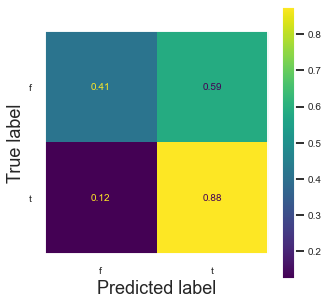

In [140]:
# Testing Reddit Sample with our model
reddit_X = reddit_sample['joined_tokens']
reddit_y = reddit_sample['t/f']

y_pred = final_sgd.predict(reddit_X)
acc_score = accuracy_score(reddit_y, y_pred)

print(classification_report(y_pred=y_pred, y_true=reddit_y, target_names=reddit_sample['t/f'].unique()))

fig, ax = plt.subplots(figsize=(5,5))
plt.rcParams.update({'font.size': 10})
plt.rc('xtick', labelsize=10) 
plt.rc('ytick', labelsize=10) 
plot_confusion_matrix(final_sgd, reddit_X, reddit_y, ax=ax, normalize='true')
plt.grid(False);

---


## Conclusion

![closer](./images/closer.png)

The task was quite difficult and the dataset was flawed, but it was possible to predict *THINKING* vs. *FEELING* types at a decently high-level simply given text chatter from this forum website. 

This verifies to a degree that *THINKING* vs. *FEELING* Myers Briggs types can be segmented by implicit user text data.

This discovery and tool can be used by social media or text-based internet companies to develop targeting strategies for digital advertising and understanding their customer base between *THINKING* vs. *FEELING* types.

The next step I will be taking is using transformers and more data to derive semantic and contextual meaning from the words to uncover more insights.

## Next Steps

This automatic personality prediction project will be ongoing to further enhance and improve the results. 
There are many cutting edge, advanced techniques for finding contextual and semantic meaning behind words, setences and documents. Over the coming months, these techniques will be applied to the dataset as well as new data. Checklist below:

- Find/use more data
- Word Embeddings
- Neural Networks w/ LSTM
- BERT
- XLNet

#### For more information
Please contact the contributors to this analysis: 
[Weston Shuken](https://www.linkedin.com/in/westonshuken/)